In [6]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!sh install_pymoo.sh


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 71.1 MB/s eta 0:00:00:00:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
fatal: destination path 'pymoo_to_adequacy' already exists and is not an empty directory.
Processing /home/coinse/kimnal/CS453/sbts/pymoo_to_adequacy
  Preparing metadata (setup.py) ... done
  Created wheel for pymoo: filename=pymoo-0.6.1.1-py3-none-any.whl size=336551 sha256=60d4f6326579bbc5cf240da9bf655c9f968f7188f159e8f13fd6850652f5c85e
  Stored in directory: /tmp/pip-ephem-wheel-cache-73mhljn8/wheels/e8/2e/1b/e66708fdab79356c6d7254a73e4eeca1e4454935958e7b6801
Successfully built pymoo
  Attempting uninstall: pymoo
    Found existing installation: pymoo 0.6.1.1
    Uninstalling pymoo-0.6.1.1:
      Successfully uninstalled pymoo-0.6.1.1


In [2]:
import numpy as np
import pandas as pd
import json

from data_preprocess import *
from run_ga import *
import matplotlib.pyplot as plt
import pickle

In [14]:
tet_path = "./data/tet.json"
fdr_path = "./data/all_class_mutation/Chart-1_fdr.json"

with open(tet_path, 'r') as f:
    tet_data = json.load(f)


with open(fdr_path, 'r') as f:
    fdr_data = json.load(f)

chart_1_tet = tet_data['Chart-1']
chart_1_fdr = dict()

for key, value in fdr_data['Chart_1'].items():
    chart_1_fdr[key] = value['mutation-score']


chart_1_tet = sorted(chart_1_tet.items())
chart_1_fdr = sorted(chart_1_fdr.items())

In [ ]:
tests = [i[0] for i in chart_1_tet]
execution_times = np.array([i[1] for i in chart_1_tet])
fault_detections = np.array([i[1] for i in chart_1_fdr])

test_cases = np.column_stack((execution_times, fault_detections))
adequacy_scores = get_adequacy_scores(fault_detections)

In [ ]:
bitflip = run_nsga(test_cases, False)

In [ ]:
adeq = run_nsga_with_adequecy(test_cases, adequacy_scores, False)

In [ ]:
datadir = 'data/experiment_result'
for pkl_file in os.listdir(datadir):
        if pkl_file.endswith('adeq.pkl'):
            with open(os.path.join(datadir, pkl_file), 'rb') as f: # load pickle file for projects from merged_data
                adeq_res  = pickle.load(f)
        elif pkl_file.endswith('flip.pkl'):
            with open(os.path.join(datadir, pkl_file), 'rb') as f: # load pickle file for projects from merged_data
               bitflip_res = pickle.load(f)
            plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
            plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
            plt.xlabel("TET")
            plt.ylabel("FDR")
            plt.legend()

In [ ]:
# bitflip_res = np.abs(bitflip.F)
# adeq_res = np.abs(adeq.F)

# plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
# plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
# plt.xlabel("TET")
# plt.ylabel("FDR")
# plt.legend()

In [ ]:
# with open('data/experiment_result/f_cov_m_all/Chart_1_bitflip.pkl', 'rb') as f:
#     bitflip = pickle.load(f)

# with open('data/experiment_result/f_cov_m_cov/Chart_1_adeq.pkl', 'rb') as f:
#     adeq = pickle.load(f)
# # print(data.F)

# bitflip_res = bitflip_res = np.abs(bitflip.F)
# adeq_res = np.abs(adeq.F)

# plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
# plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
# plt.xlabel("TET")
# plt.ylabel("Effectiveness")
# plt.legend()

## Min TET

In [ ]:
types = [
    'f_cov_m_cov',
    'f_cov_m_fdr',
    'f_cov_m_flc',
    'f_cov_m_latest',
    'f_fdr_m_cov',
    'f_fdr_m_fdr',
    'f_fdr_m_flc',
    'f_fdr_m_latest'
]

tet_dict = {}

for type in types:
    result_dir = f'./data/experiment_result/40_generation/{type}'
    for target in os.listdir('./data/merged_data'):
        pid, vid = os.path.splitext(target)[0].split('_')

        # with open(f'data/experiment_result/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
        with open(os.path.join(result_dir, f'{pid}_{vid}_bitflip.pkl'), 'rb') as f:
            bitflip = pickle.load(f)

        with open(os.path.join(result_dir, f'{pid}_{vid}_adeq.pkl'), 'rb') as f:
            adeq = pickle.load(f)

        with open(f'data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
            data = pickle.load(f)

        with open(f"data/failing_tests/{pid}-{vid}/failing_tests", "r") as f:
            failing_tests = f.readlines()

        min_id_adeq = None
        for i, sol in enumerate(adeq.X):
            # print(data.index[sol].shape)
            selected_tests = data.index[sol]
            if all(test in selected_tests for test in failing_tests):
                tet = adeq.F[i, 0]
                if min_id_adeq == None:
                    min_id_adeq = i
                elif tet < adeq.F[min_id_adeq, 0]:
                    min_id_adeq = i

        min_id_bitflip = None
        for i, sol in enumerate(bitflip.X):
            # print(data.index[sol].shape)
            selected_tests = data.index[sol]
            if all(test in selected_tests for test in failing_tests):
                tet = bitflip.F[i, 0]
                if min_id_bitflip == None:
                    min_id_bitflip = i
                elif tet < bitflip.F[min_id_bitflip, 0]:
                    min_id_bitflip = i

        # print("Adeq tet")
        # print(adeq.F[min_id_adeq, 0])
        # print("Bitflip tet")
        # print(bitflip.F[min_id_bitflip, 0])
        # print("\n")

        min_tet_w_fail_adeq = adeq.F[min_id_adeq, 0]
        min_tet_w_fail_bitflip = bitflip.F[min_id_bitflip, 0]

        # 솔루션들이 모두 failing test를 포함하지 않는 경우 tet를 9999로 설정
        if min_id_adeq == None:
            min_tet_w_fail_adeq = 9999.0
        if min_id_bitflip == None:
            min_tet_w_fail_bitflip = 9999.0
        
        tet_dict[f"{pid}_{vid}"] = {"adeq": min_tet_w_fail_adeq, "bitflip": min_tet_w_fail_bitflip}
    # with
    print(type)
    print(tet_dict)
    with open(os.path.join(result_dir, f"min_tet_with_failing_tests.json"), 'w') as f:
        json.dump(tet_dict, f)


## Real Mutation Result

JxPath_22.pkl


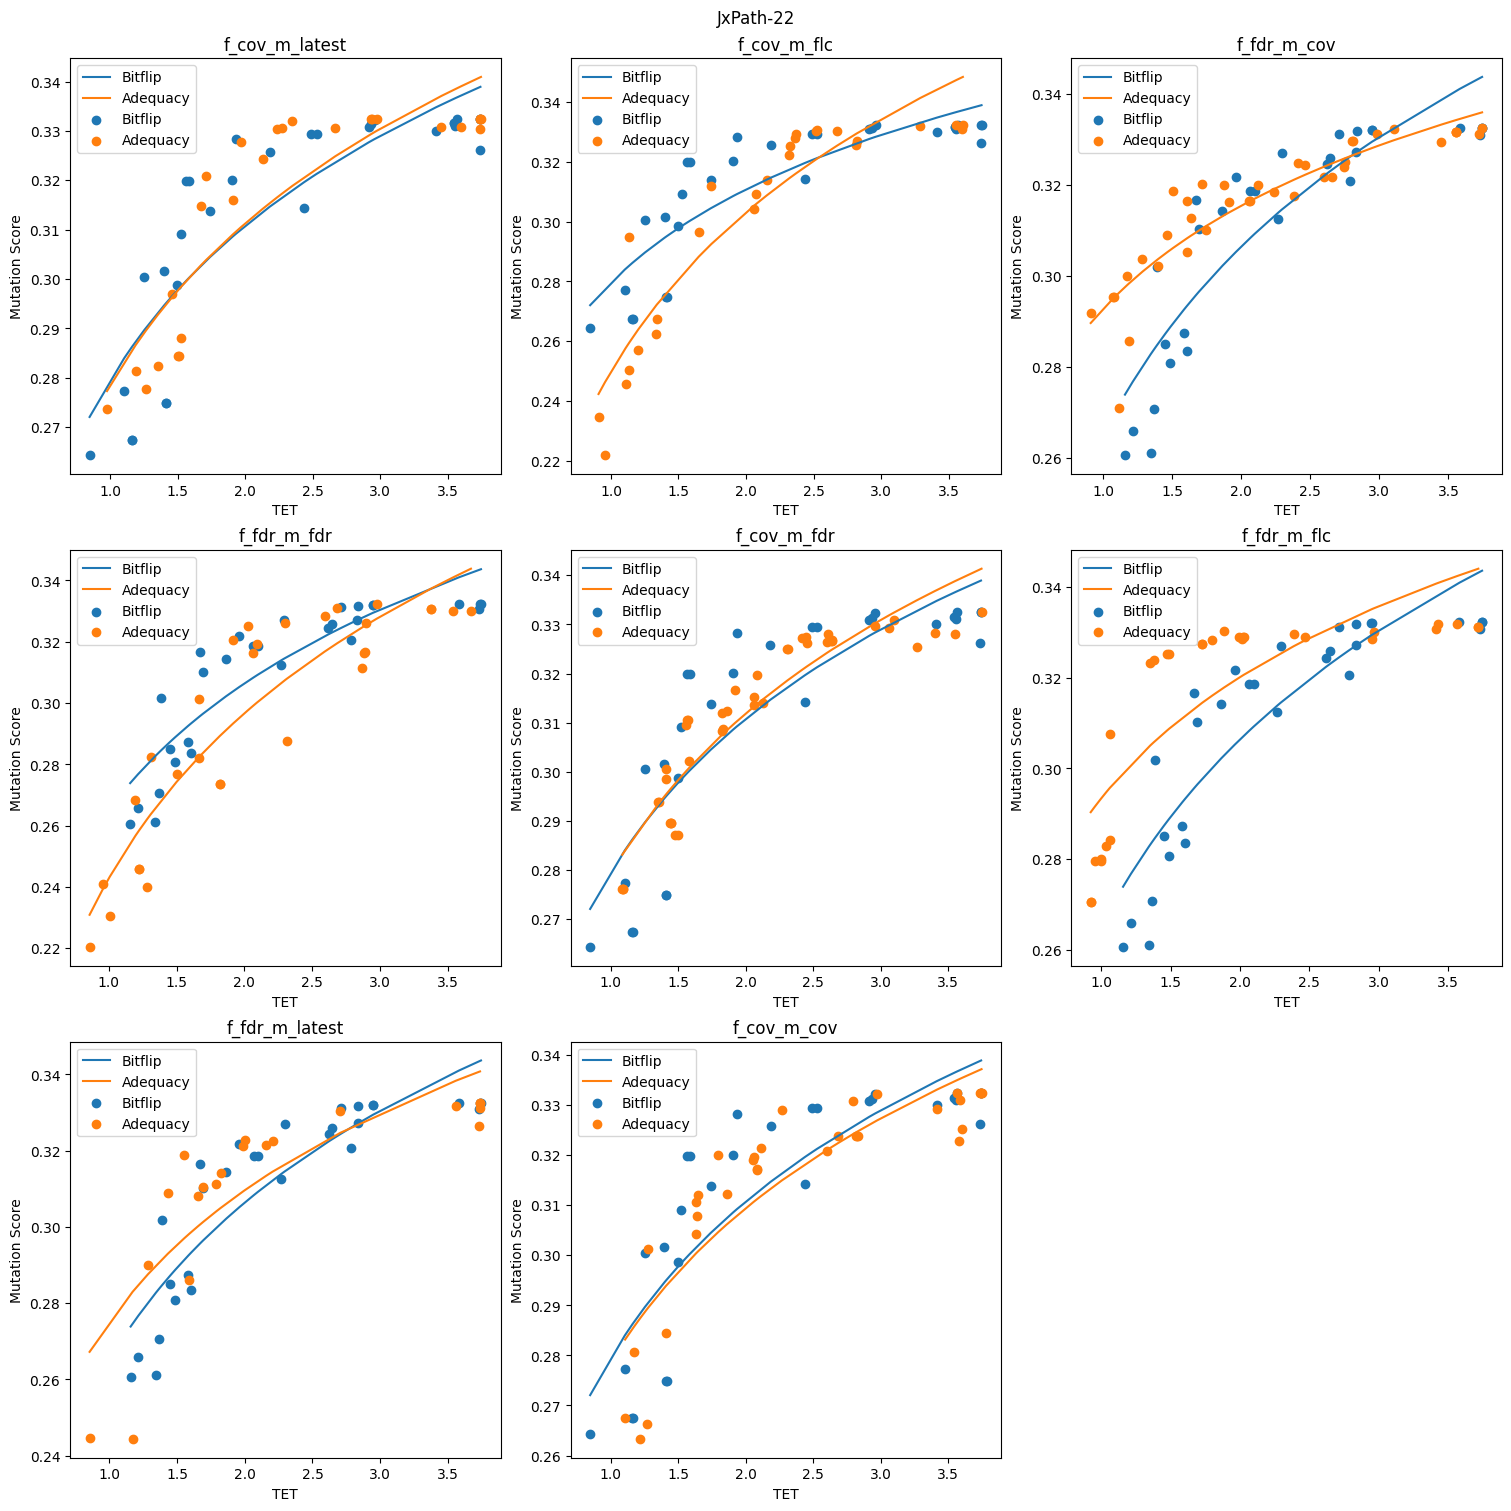

Cli_40.pkl


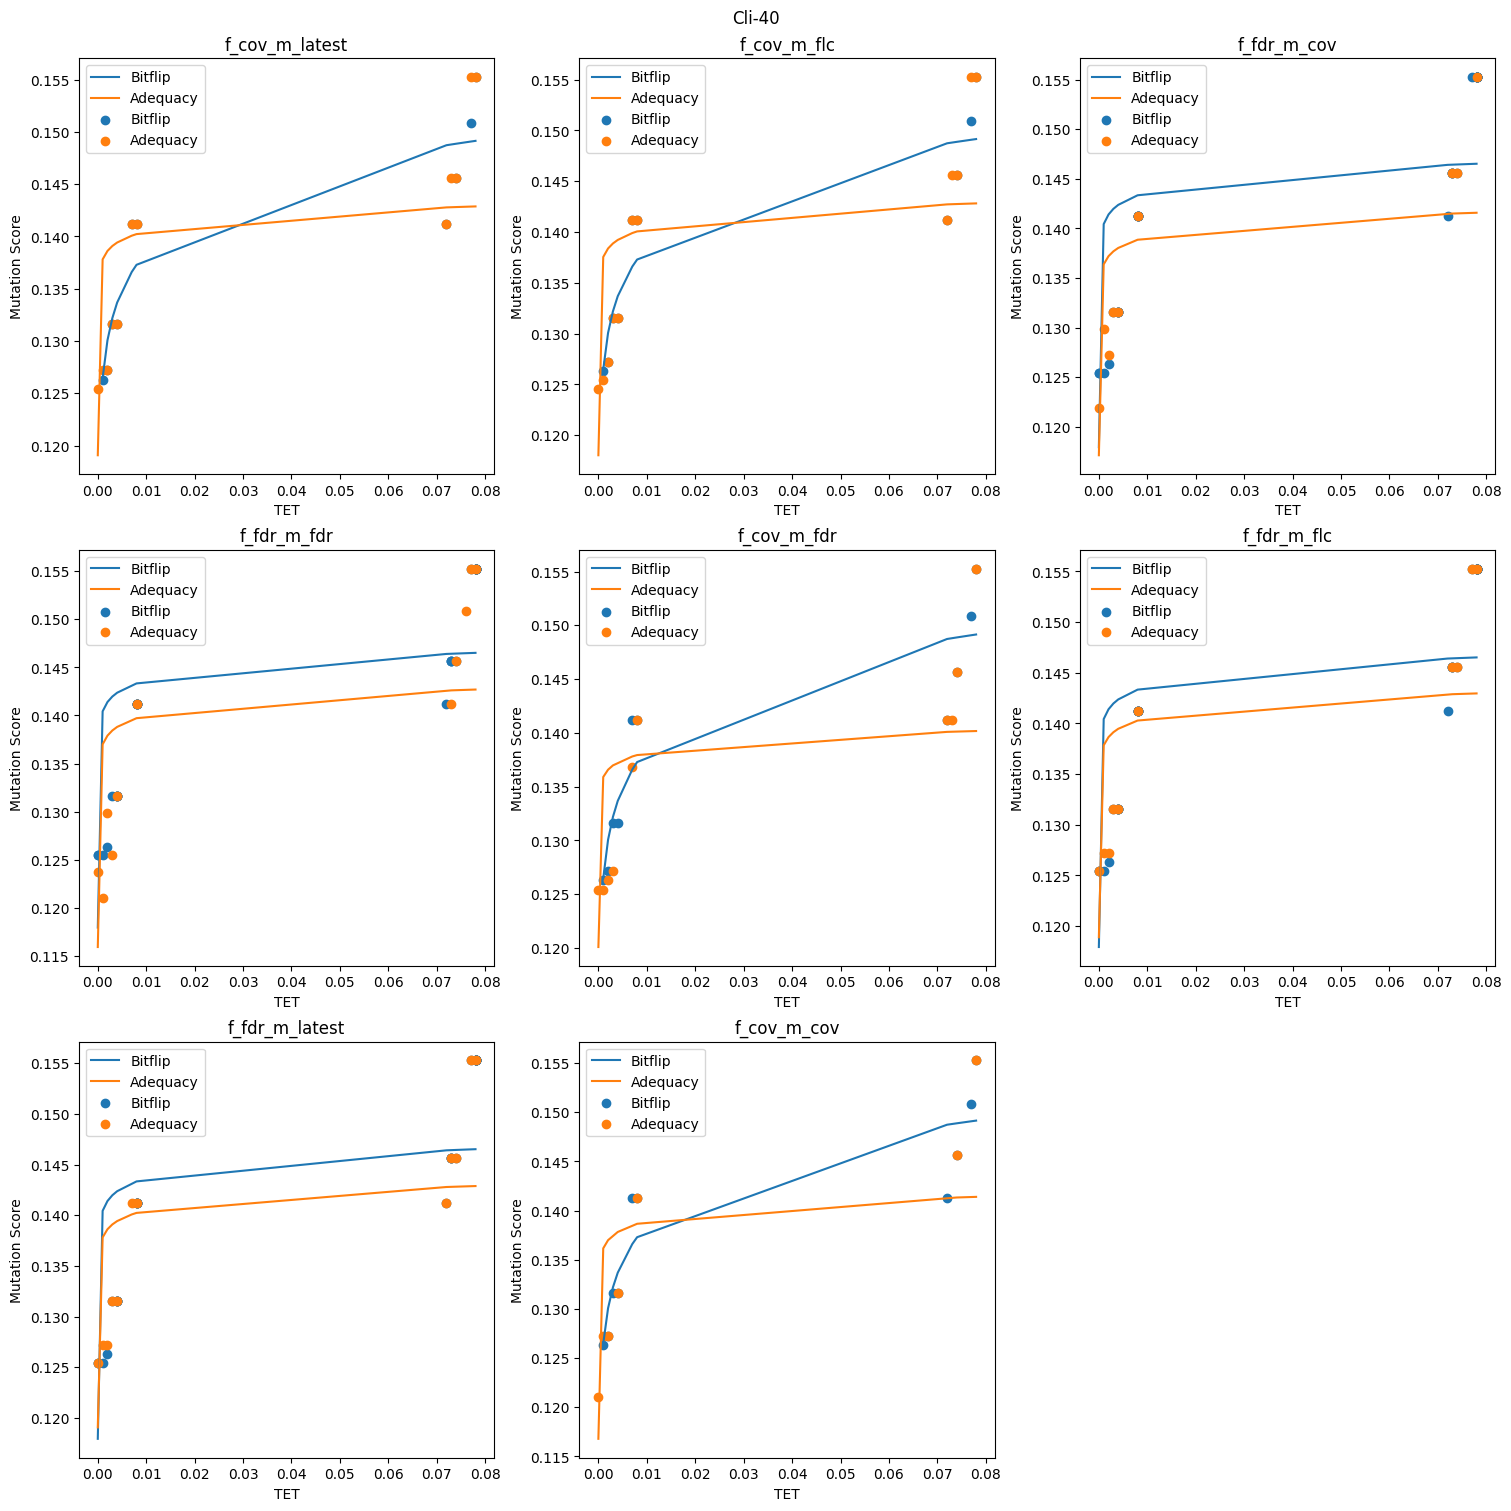

Lang_1.pkl


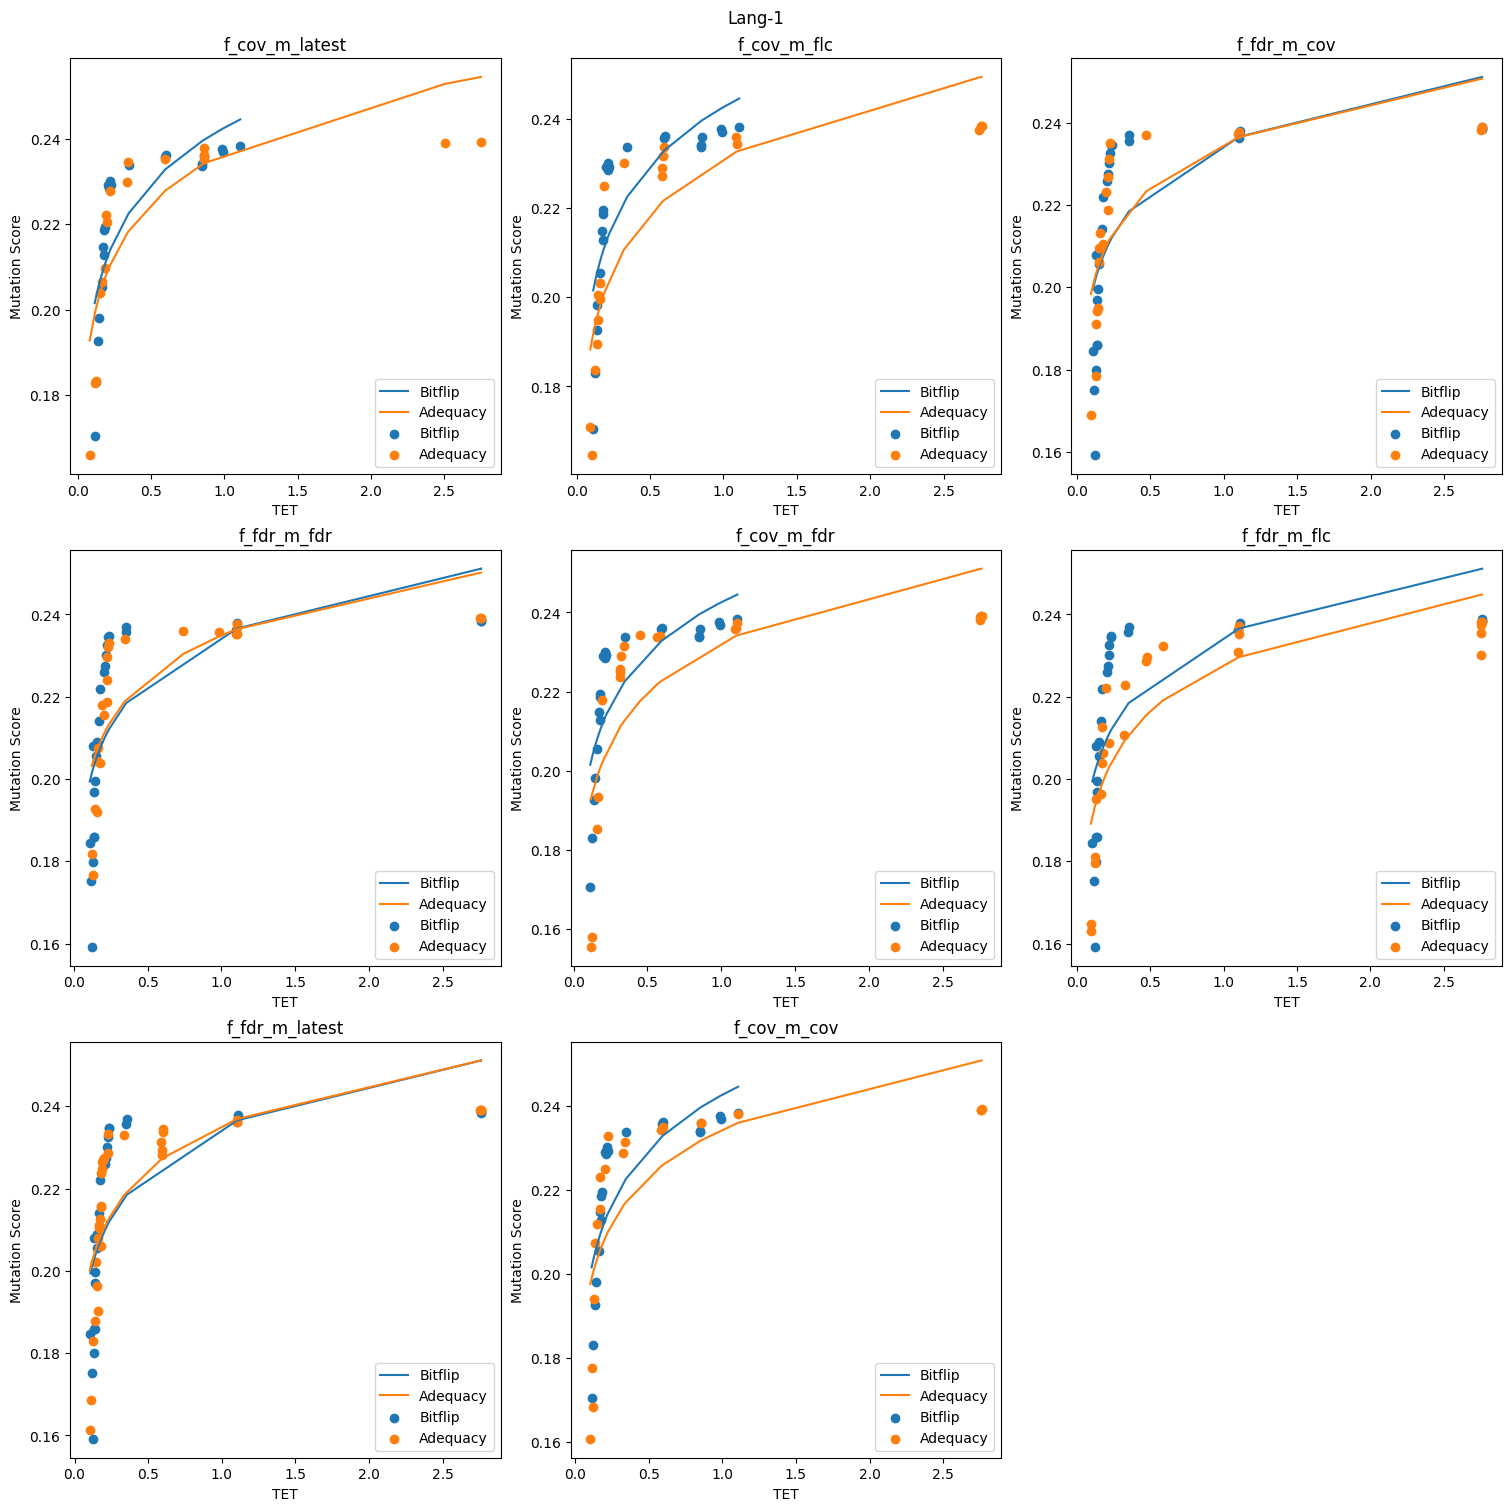

Time_1.pkl


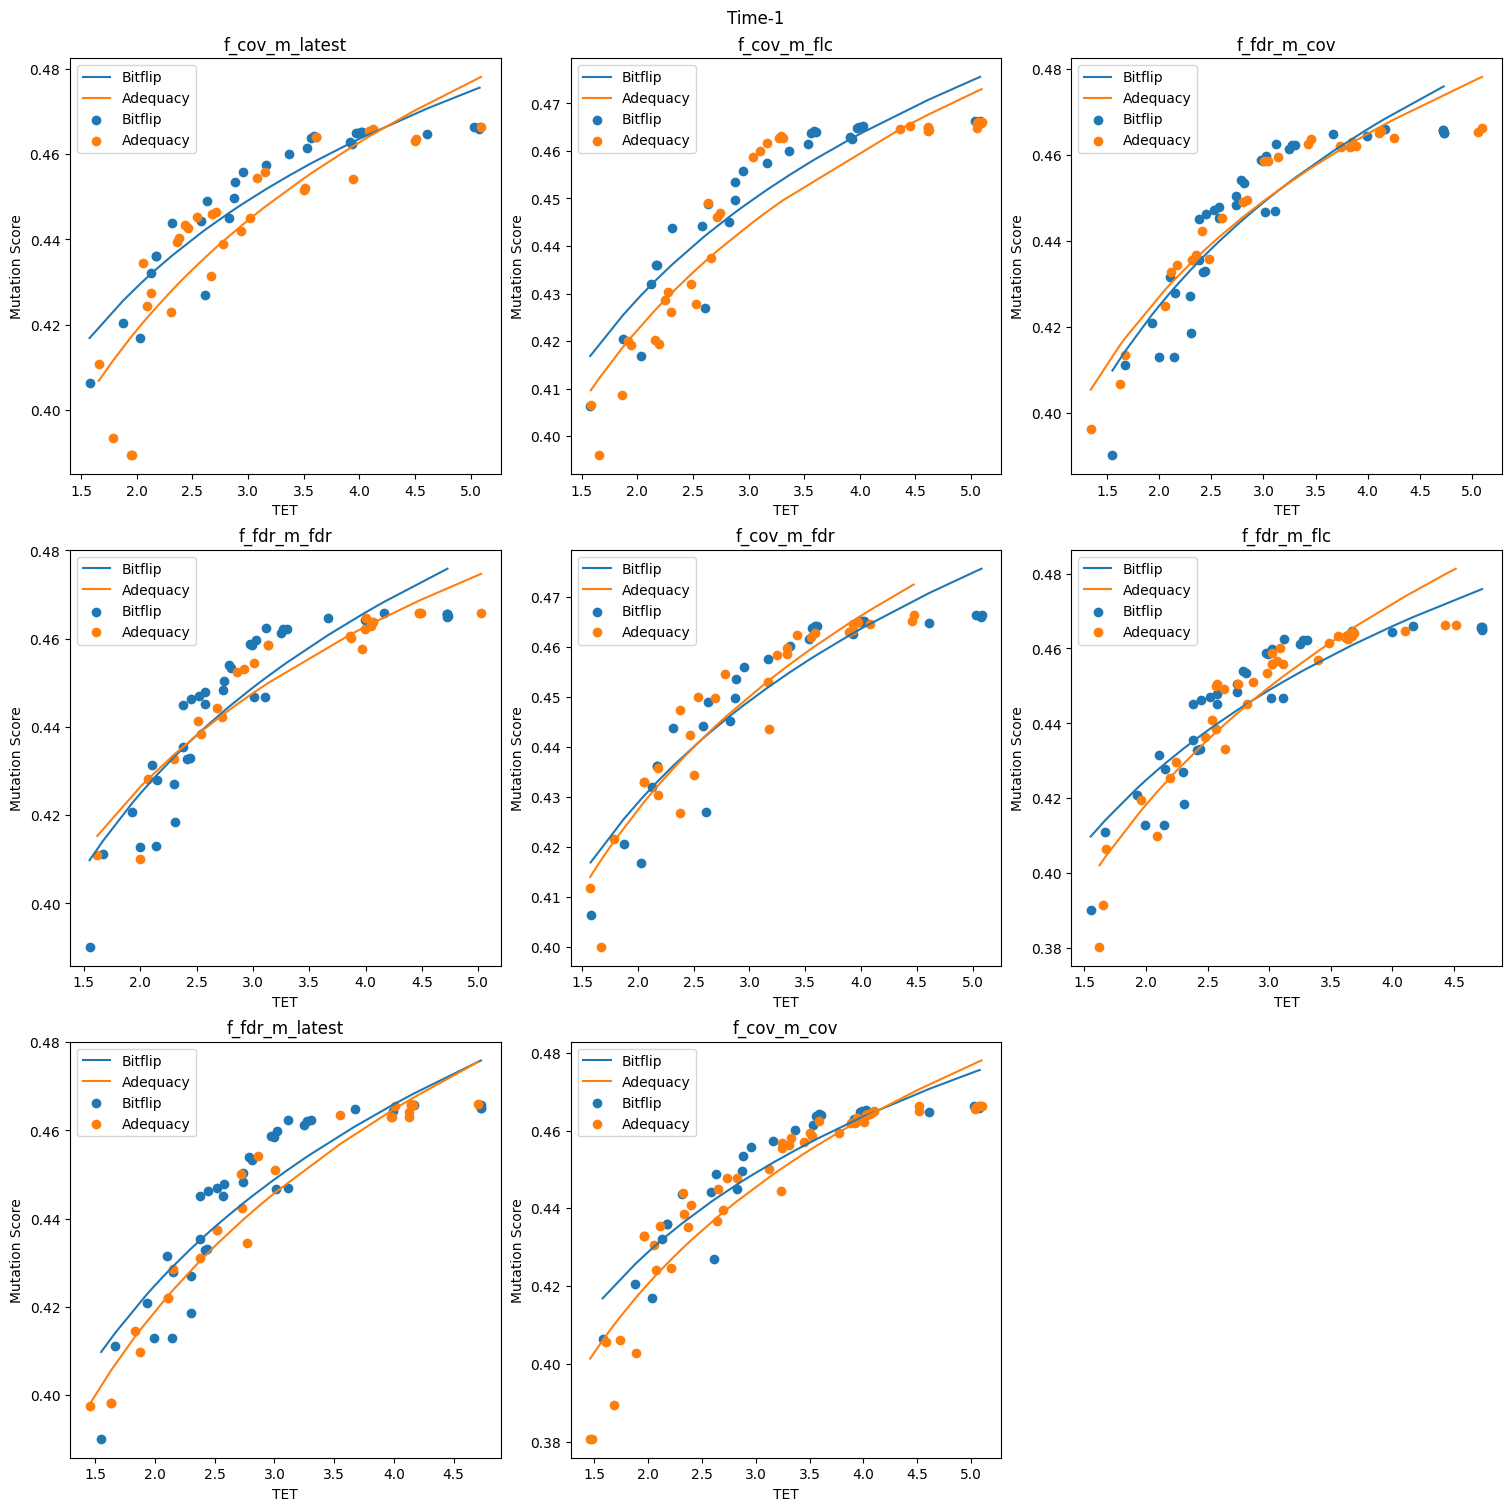

JacksonCore_26.pkl


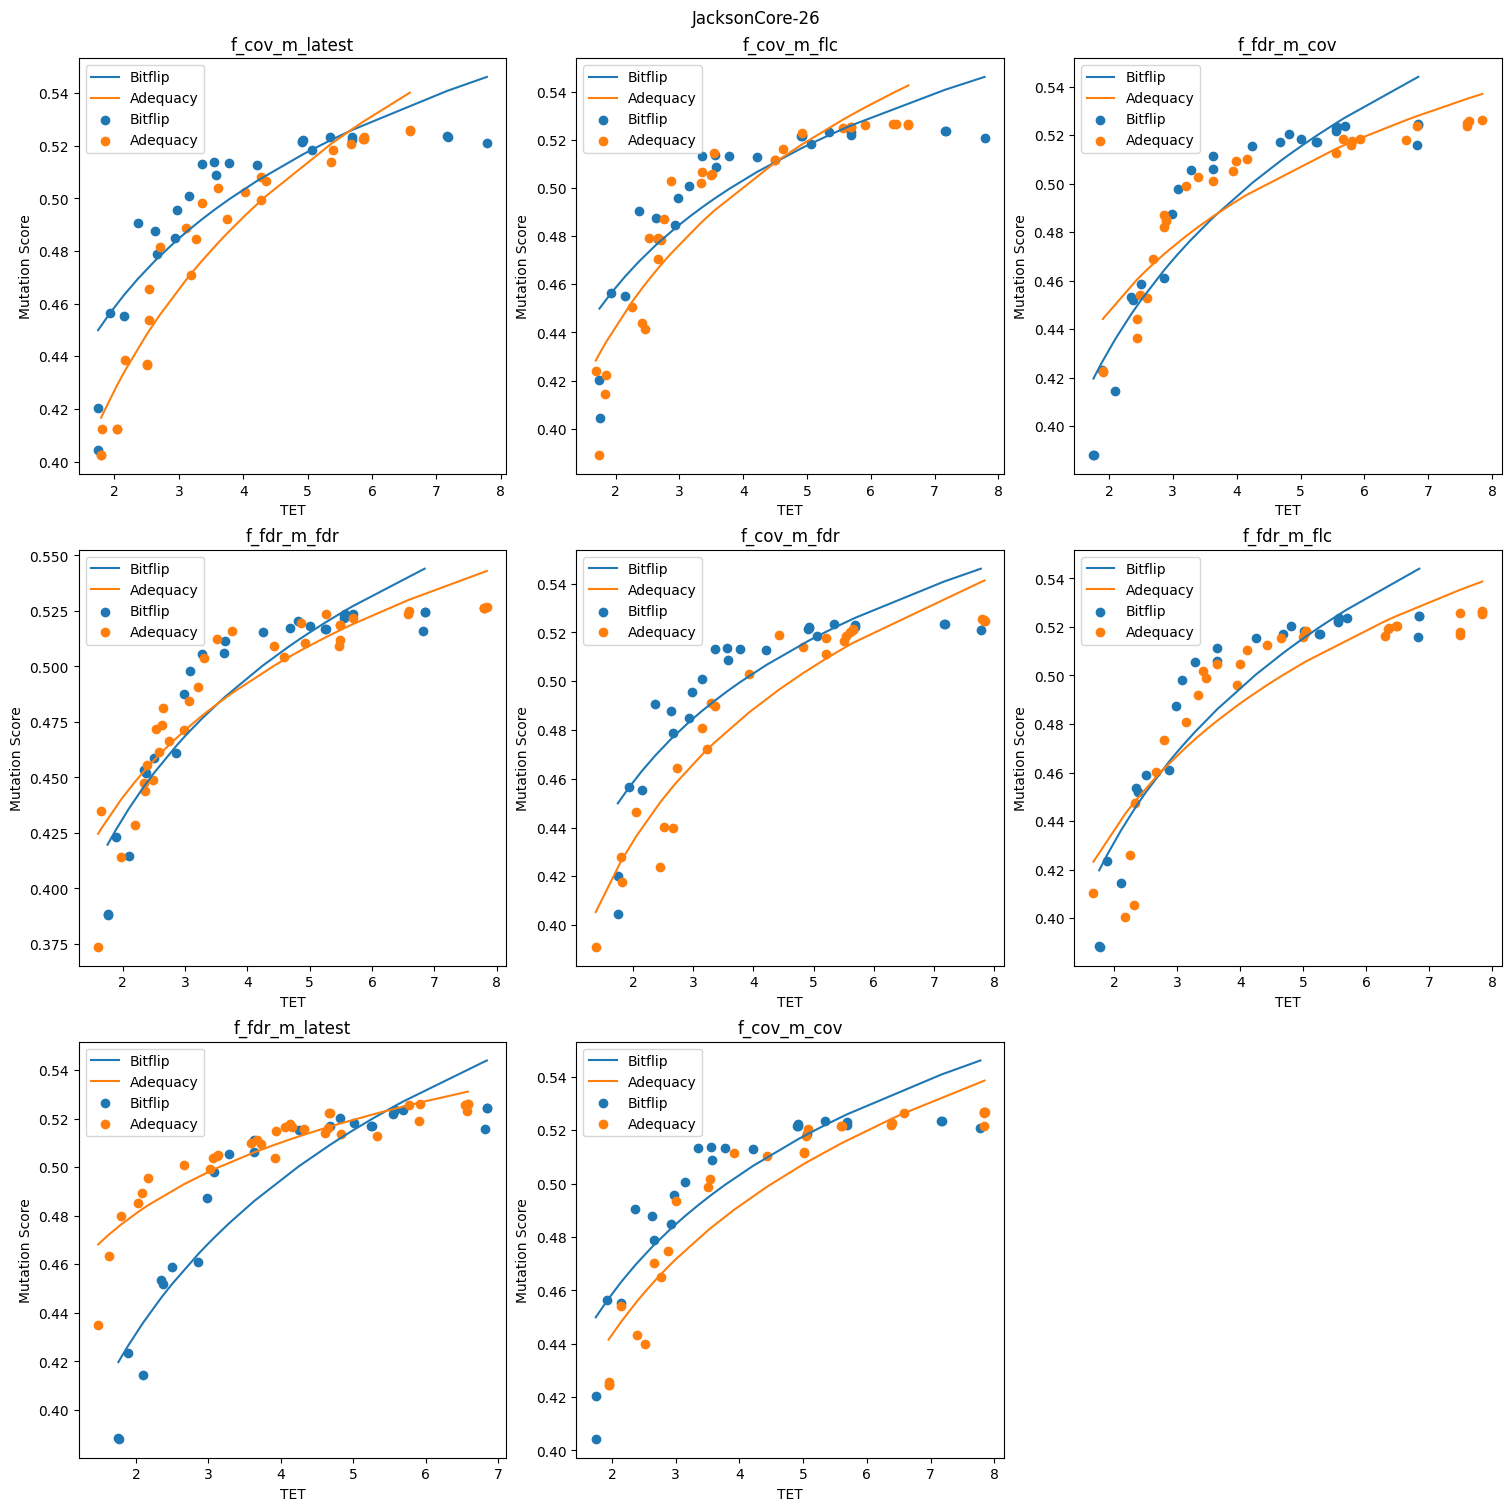

Chart_1.pkl
Csv_16.pkl


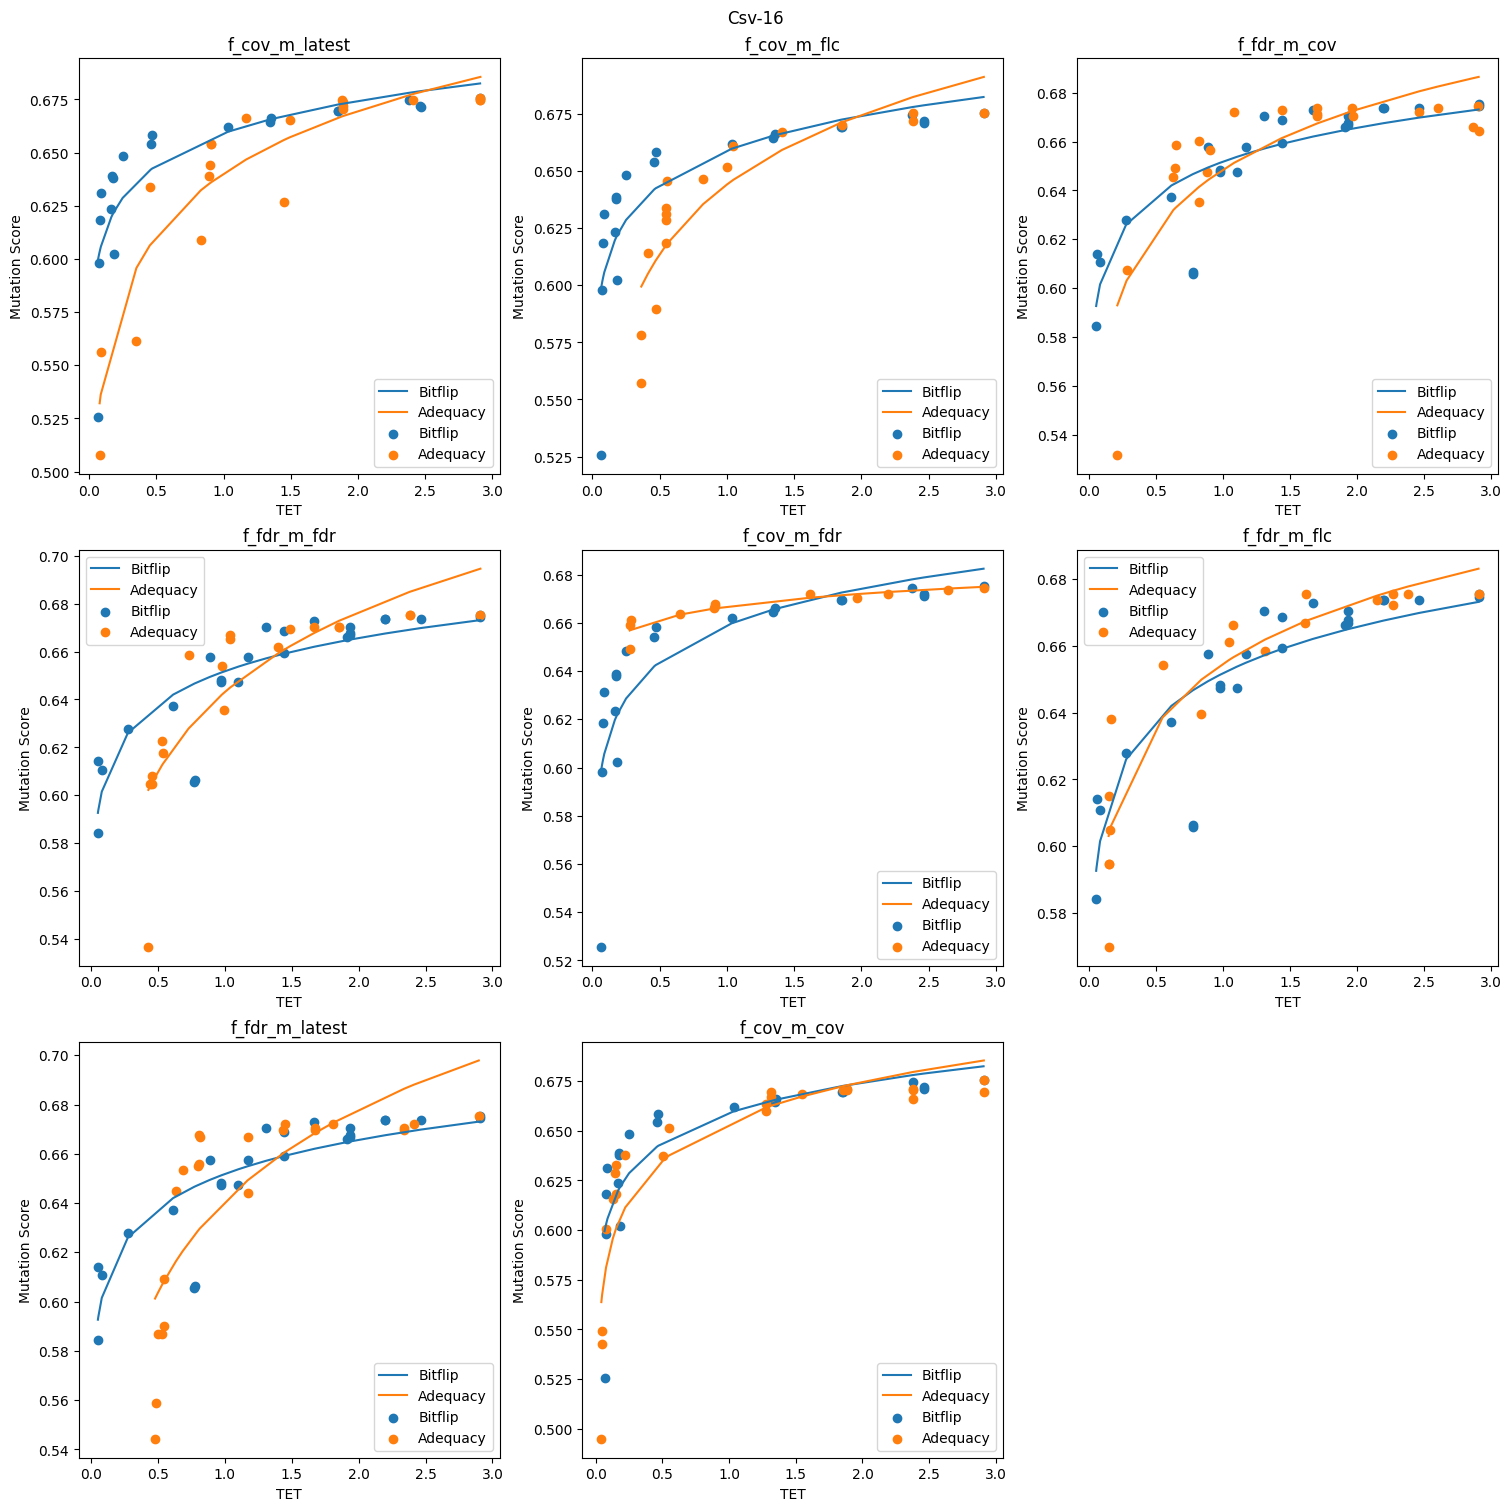

In [25]:
result_dir = "./data/experiment_result/40_generation/"

for target in os.listdir('./data/merged_data/'):
    print(target)
    pid, vid = os.path.splitext(target)[0].split('_')
    # There is no data for Chart_1 ####
    if pid == "Chart":
        continue
    #####################
    plt.figure(figsize=(15, 15), constrained_layout=True)
    for j, type in enumerate(os.listdir(result_dir)):
        ax = plt.subplot(3, 3, j+1)

        with open(f'./data/experiment_result/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
            bitflip = pickle.load(f)
        with open(f'./data/experiment_result/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
            adeq = pickle.load(f)
        with open(f'./data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
            merged_data = pickle.load(f)
        with open(f"./data/killmap/{pid}-{vid}_fdr.json", "rb") as f:
            killmap = json.load(f)[f"{pid}_{vid}"]
        with open(f"./data/all_class_mutation/{pid}-{vid}_fdr.json", "rb") as f:
            fdr = json.load(f)[f"{pid}_{vid}"]

        total_mutant = fdr[list(fdr.keys())[0]]["mutants-generated"]
        
        bitflip_result = []
        adeq_result = []
        for i, sol in enumerate(bitflip.X):
            bitflip_kill = set()
            for test in merged_data.index[sol]:
                if test in killmap:
                    bitflip_kill = bitflip_kill.union(set(killmap[test]))
            mut_score = len(bitflip_kill) / total_mutant
            bitflip_result.append([bitflip.F[i][0], mut_score])
        
        for i, sol in enumerate(adeq.X):
            adeq_kill = set()
            for test in merged_data.index[sol]:
                if test in killmap:
                    adeq_kill = adeq_kill.union(set(killmap[test]))
            mut_score = len(adeq_kill) / total_mutant
            adeq_result.append([adeq.F[i][0], mut_score])
        
        bitflip_result = np.array(bitflip_result)
        adeq_result = np.array(adeq_result)
        
        bitflip_result = bitflip_result[bitflip_result[:, 0].argsort()]
        adeq_result = adeq_result[adeq_result[:, 0].argsort()]

        x_b = bitflip_result[:, 0]
        x_a = adeq_result[:, 0]

        epsilon = 1e-10
        x_b_log = x_b + epsilon
        x_a_log = x_a + epsilon

        # 2차 함수로 fitting
        # fit_bitflip = np.polyfit(bitflip_result[:, 0], bitflip_result[:, 1], 2)
        # fit_adeq = np.polyfit(adeq_result[:, 0], adeq_result[:, 1], 2)
        # plt.plot(x_b, fit_bitflip[0] * (x_b ** 2) + fit_bitflip[1] * (x_b ** 1) + fit_bitflip[2], label="Bitflip")
        # plt.plot(x_a, fit_adeq[0] * (x_a ** 2) + fit_adeq[1] * (x_a ** 1) + fit_adeq[2], label="Adequacy")

        # log 함수로 fitting
        fit_bitflip = np.polyfit(np.log(x_b_log), bitflip_result[:, 1], 1)
        fit_adeq = np.polyfit(np.log(x_a_log), adeq_result[:, 1], 1)
        plt.plot(x_b, fit_bitflip[0] * np.log(x_b_log) + fit_bitflip[1], label="Bitflip")
        plt.plot(x_a, fit_adeq[0] * np.log(x_a_log) + fit_adeq[1], label="Adequacy")


        plt.scatter(bitflip_result[:, 0], bitflip_result[:, 1], label="Bitflip")
        plt.scatter(adeq_result[:, 0], adeq_result[:, 1], label="Adequacy")

        plt.xlabel("TET")
        plt.ylabel("Mutation Score")
        plt.title(type)
        plt.legend()

    plt.suptitle(f"{pid}-{vid}")
    plt.show()

## Pareto Dominance Comparison

In [43]:
def dominates(point1, point2):
    return (point1[0] < point2[0]) or (point1[1] > point2[1])

In [45]:
result_dir = "./data/experiment_result/"

for j, type in enumerate(os.listdir(result_dir)):
    for target in os.listdir('./data/merged_data'):
        pid, vid = os.path.splitext(target)[0].split('_')

        # only for Csv-16####
        if pid != "Csv":
            continue
        #####################

        print(type)

        with open(f'./data/experiment_result/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
            bitflip = pickle.load(f)
        with open(f'./data/experiment_result/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
            adeq = pickle.load(f)
        with open(f'./data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
            merged_data = pickle.load(f)
        with open(f"./data/killmap/{pid}-{vid}_fdr.json", "rb") as f:
            killmap = json.load(f)[f"{pid}_{vid}"]

        total_mutant = fdr[list(fdr.keys())[0]]["mutants-generated"]
        
        bitflip_result = []
        adeq_result = []
        for i, sol in enumerate(bitflip.X):
            bitflip_kill = set()
            for test in merged_data.index[sol]:
                if test in killmap:
                    bitflip_kill = bitflip_kill.union(set(killmap[test]))
            mut_score = len(bitflip_kill) / total_mutant
            bitflip_result.append([bitflip.F[i][0], mut_score])
        
        for i, sol in enumerate(adeq.X):
            adeq_kill = set()
            for test in merged_data.index[sol]:
                if test in killmap:
                    adeq_kill = adeq_kill.union(set(killmap[test]))
            mut_score = len(adeq_kill) / total_mutant
            adeq_result.append([adeq.F[i][0], mut_score])
        
        combined_set = bitflip_result + adeq_result

        pareto_frontier = []
        for point in combined_set:
            if all(dominates(point, other_point) for other_point in combined_set if other_point != point):
                pareto_frontier.append(point)

        bitflip_contribution = sum(1 for point in pareto_frontier if point in bitflip_result)
        adeq_contribution = sum(1 for point in pareto_frontier if point in adeq_result)

        print(bitflip_contribution, adeq_contribution)
        

f_cov_m_latest
11 2
f_cov_m_flc
13 3
f_fdr_m_cov
5 8
f_fdr_m_fdr
7 4
f_cov_m_fdr
8 8
f_fdr_m_flc
4 6
f_fdr_m_latest
7 7
f_cov_m_cov
10 10


## Hypervolume Calculation

In [48]:
def calculate_hypervolume(front, reference):
    hypervolume = 0
    for point in front:
        volume = abs((reference[0]-point[0])*(reference[1]-point[1]))
        hypervolume += volume
    return hypervolume

In [50]:
result_dir = "./data/experiment_result/"

for j, type in enumerate(os.listdir(result_dir)):
    for target in os.listdir('./data/merged_data'):
        pid, vid = os.path.splitext(target)[0].split('_')

        # only for Csv-16####
        if pid != "Csv":
            continue
        #####################

        print(type)

        with open(f'./data/experiment_result/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
            bitflip = pickle.load(f)
        with open(f'./data/experiment_result/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
            adeq = pickle.load(f)
        with open(f'./data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
            merged_data = pickle.load(f)
        with open(f"./data/killmap/{pid}-{vid}_fdr.json", "rb") as f:
            killmap = json.load(f)[f"{pid}_{vid}"]

        total_mutant = fdr[list(fdr.keys())[0]]["mutants-generated"]
        
        bitflip_result = []
        adeq_result = []
        for i, sol in enumerate(bitflip.X):
            bitflip_kill = set()
            for test in merged_data.index[sol]:
                if test in killmap:
                    bitflip_kill = bitflip_kill.union(set(killmap[test]))
            mut_score = len(bitflip_kill) / total_mutant
            bitflip_result.append([bitflip.F[i][0], mut_score])
        
        for i, sol in enumerate(adeq.X):
            adeq_kill = set()
            for test in merged_data.index[sol]:
                if test in killmap:
                    adeq_kill = adeq_kill.union(set(killmap[test]))
            mut_score = len(adeq_kill) / total_mutant
            adeq_result.append([adeq.F[i][0], mut_score])
        max_tet = max(max(bitflip_result[:][0]), max(adeq_result[:][0]))
        min_fdr = min(min(bitflip_result[:][1]), min(adeq_result[:][1]))
        
        reference_point = [max_tet+0.001, max(min_fdr-0.001, 0)]

        bitflip_hypervolume = calculate_hypervolume(bitflip_result, reference_point)
        adeq_hypervolume = calculate_hypervolume(adeq_result, reference_point)

        print(bitflip_hypervolume, adeq_hypervolume)


f_cov_m_latest
9.452032753445609 11.458888874518603
f_cov_m_flc
4.8792196847394855 3.022086865510246
f_fdr_m_cov
0.2542271586590787 0.1591400145892406
f_fdr_m_fdr
0.3100907240204431 0.2554914344122659
f_cov_m_fdr
6.2283186165644615 3.867912647188227
f_fdr_m_flc
11.930555011768323 8.048194880717649
f_fdr_m_latest
3.747335420626929 2.555053262707905
f_cov_m_cov
10.21275229448093 13.59351186751855


## For each generation

### Pareto Dominance Comparison

In [7]:
def dominates(point1, point2):
    #return (point1[0] < point2[0]) or (point1[1] > point2[1])
    return (point1[0] <= point2[0] and point1[1] >= point2[1]) and (point1[0] < point2[0] and point1[1] > point2[1])

JxPath_22.pkl
f_cov_m_latest
[5, 17, 6, 14]
[2, 2, 3, 15]
f_cov_m_flc
[4, 12, 5, 12]
[5, 5, 4, 19]
f_fdr_m_cov
[3, 7, 3, 2]
[5, 3, 12, 8]
f_fdr_m_fdr
[3, 6, 4, 2]
[5, 3, 16, 8]
f_cov_m_fdr
[3, 14, 6, 11]
[8, 7, 5, 24]
f_fdr_m_flc
[2, 7, 6, 4]
[5, 9, 10, 9]
f_fdr_m_latest
[2, 7, 1, 2]
[6, 3, 12, 10]
f_cov_m_cov
[5, 18, 6, 14]
[4, 3, 7, 5]


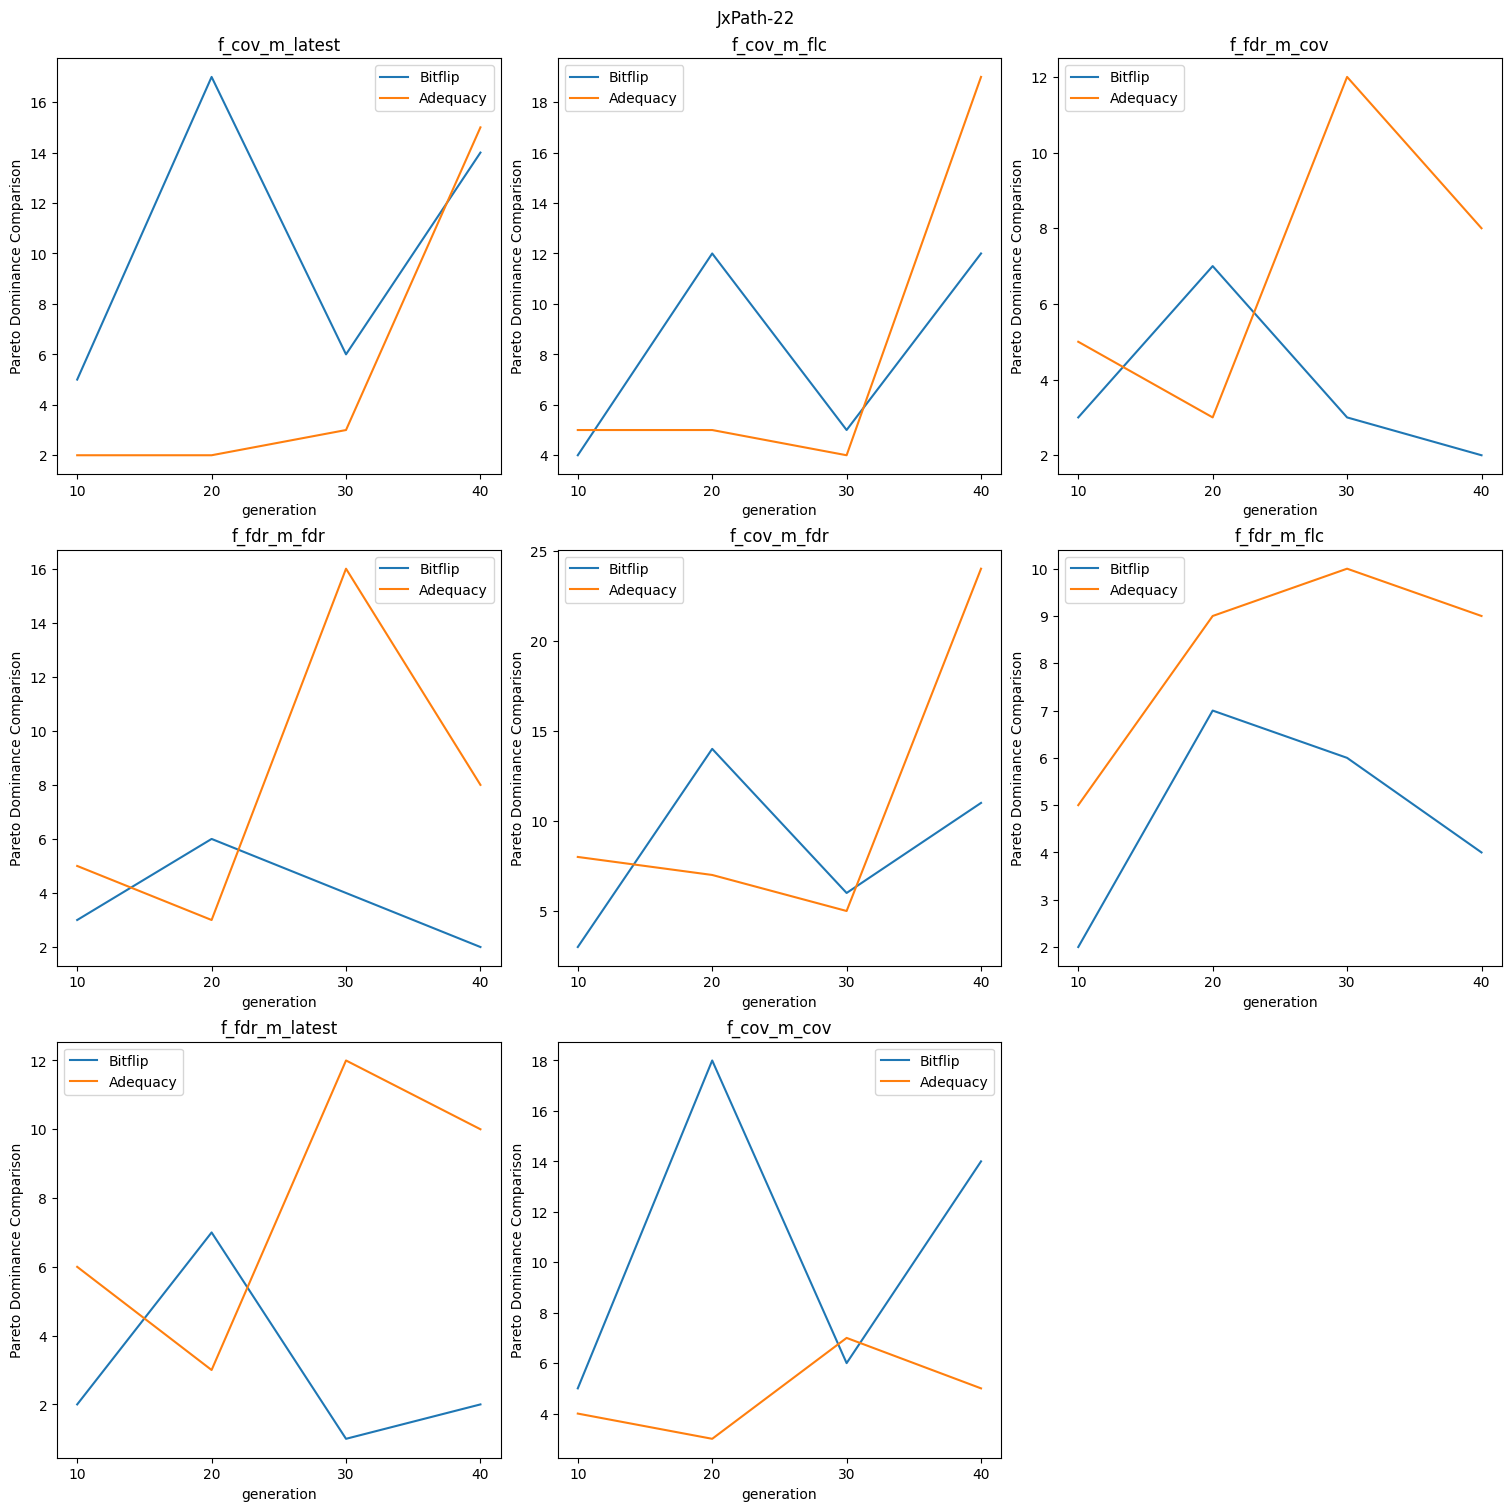

Cli_40.pkl
f_cov_m_latest
[4, 13, 16, 18]
[7, 12, 17, 21]
f_cov_m_flc
[4, 10, 16, 14]
[10, 10, 17, 15]
f_fdr_m_cov
[10, 15, 21, 26]
[10, 8, 18, 21]
f_fdr_m_fdr
[14, 16, 23, 26]
[10, 13, 23, 19]
f_cov_m_fdr
[3, 10, 15, 15]
[8, 10, 15, 14]
f_fdr_m_flc
[11, 15, 22, 28]
[10, 13, 19, 21]
f_fdr_m_latest
[13, 15, 22, 30]
[7, 7, 19, 29]
f_cov_m_cov
[5, 13, 12, 17]
[7, 12, 10, 17]


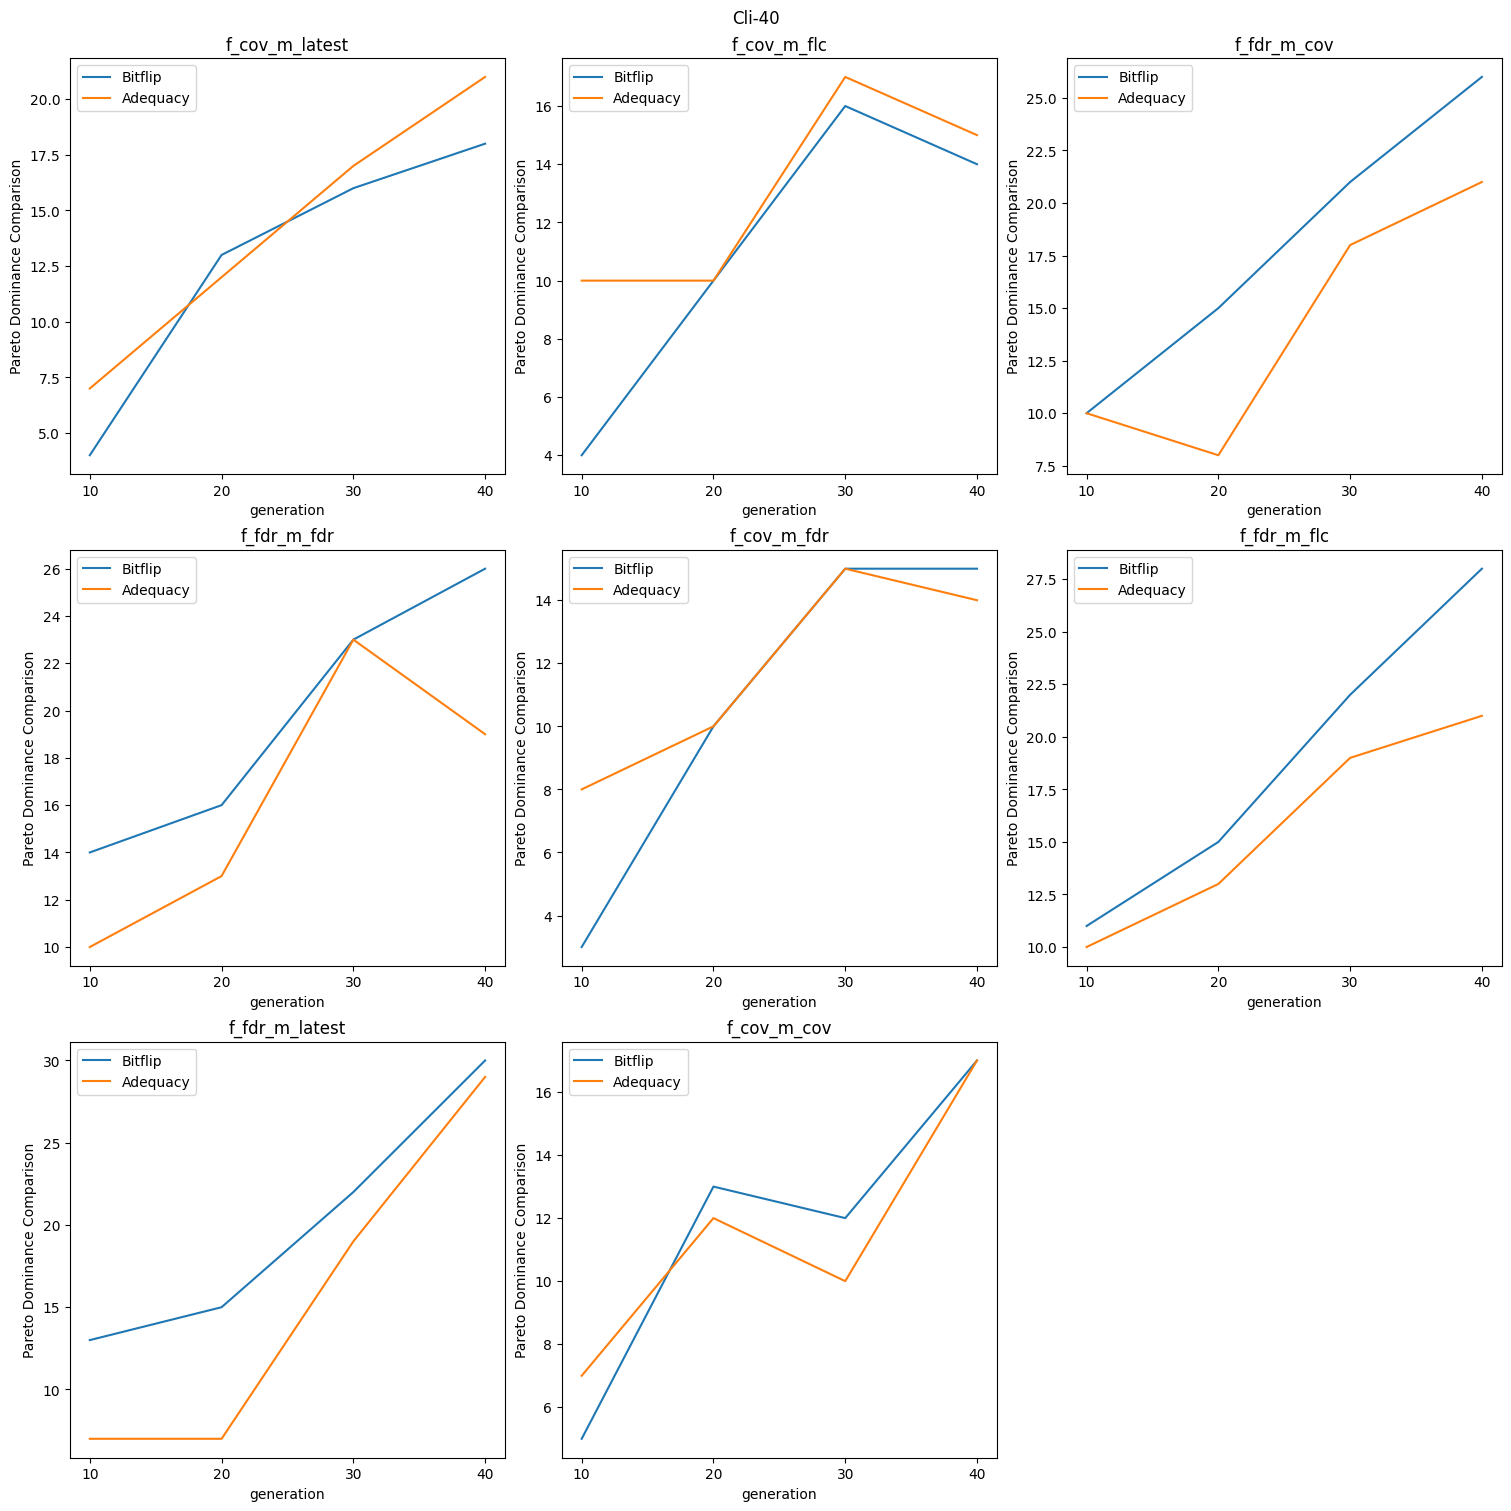

Lang_1.pkl
f_cov_m_latest
[7, 7, 10, 10]
[6, 8, 13, 15]
f_cov_m_flc
[6, 9, 12, 9]
[9, 8, 10, 12]
f_fdr_m_cov
[5, 8, 6, 9]
[3, 11, 13, 12]
f_fdr_m_fdr
[6, 8, 6, 10]
[5, 14, 15, 10]
f_cov_m_fdr
[3, 11, 8, 8]
[7, 4, 10, 9]
f_fdr_m_flc
[6, 10, 7, 10]
[5, 8, 8, 11]
f_fdr_m_latest
[6, 7, 8, 10]
[3, 8, 11, 9]
f_cov_m_cov
[8, 11, 10, 2]
[5, 4, 13, 15]


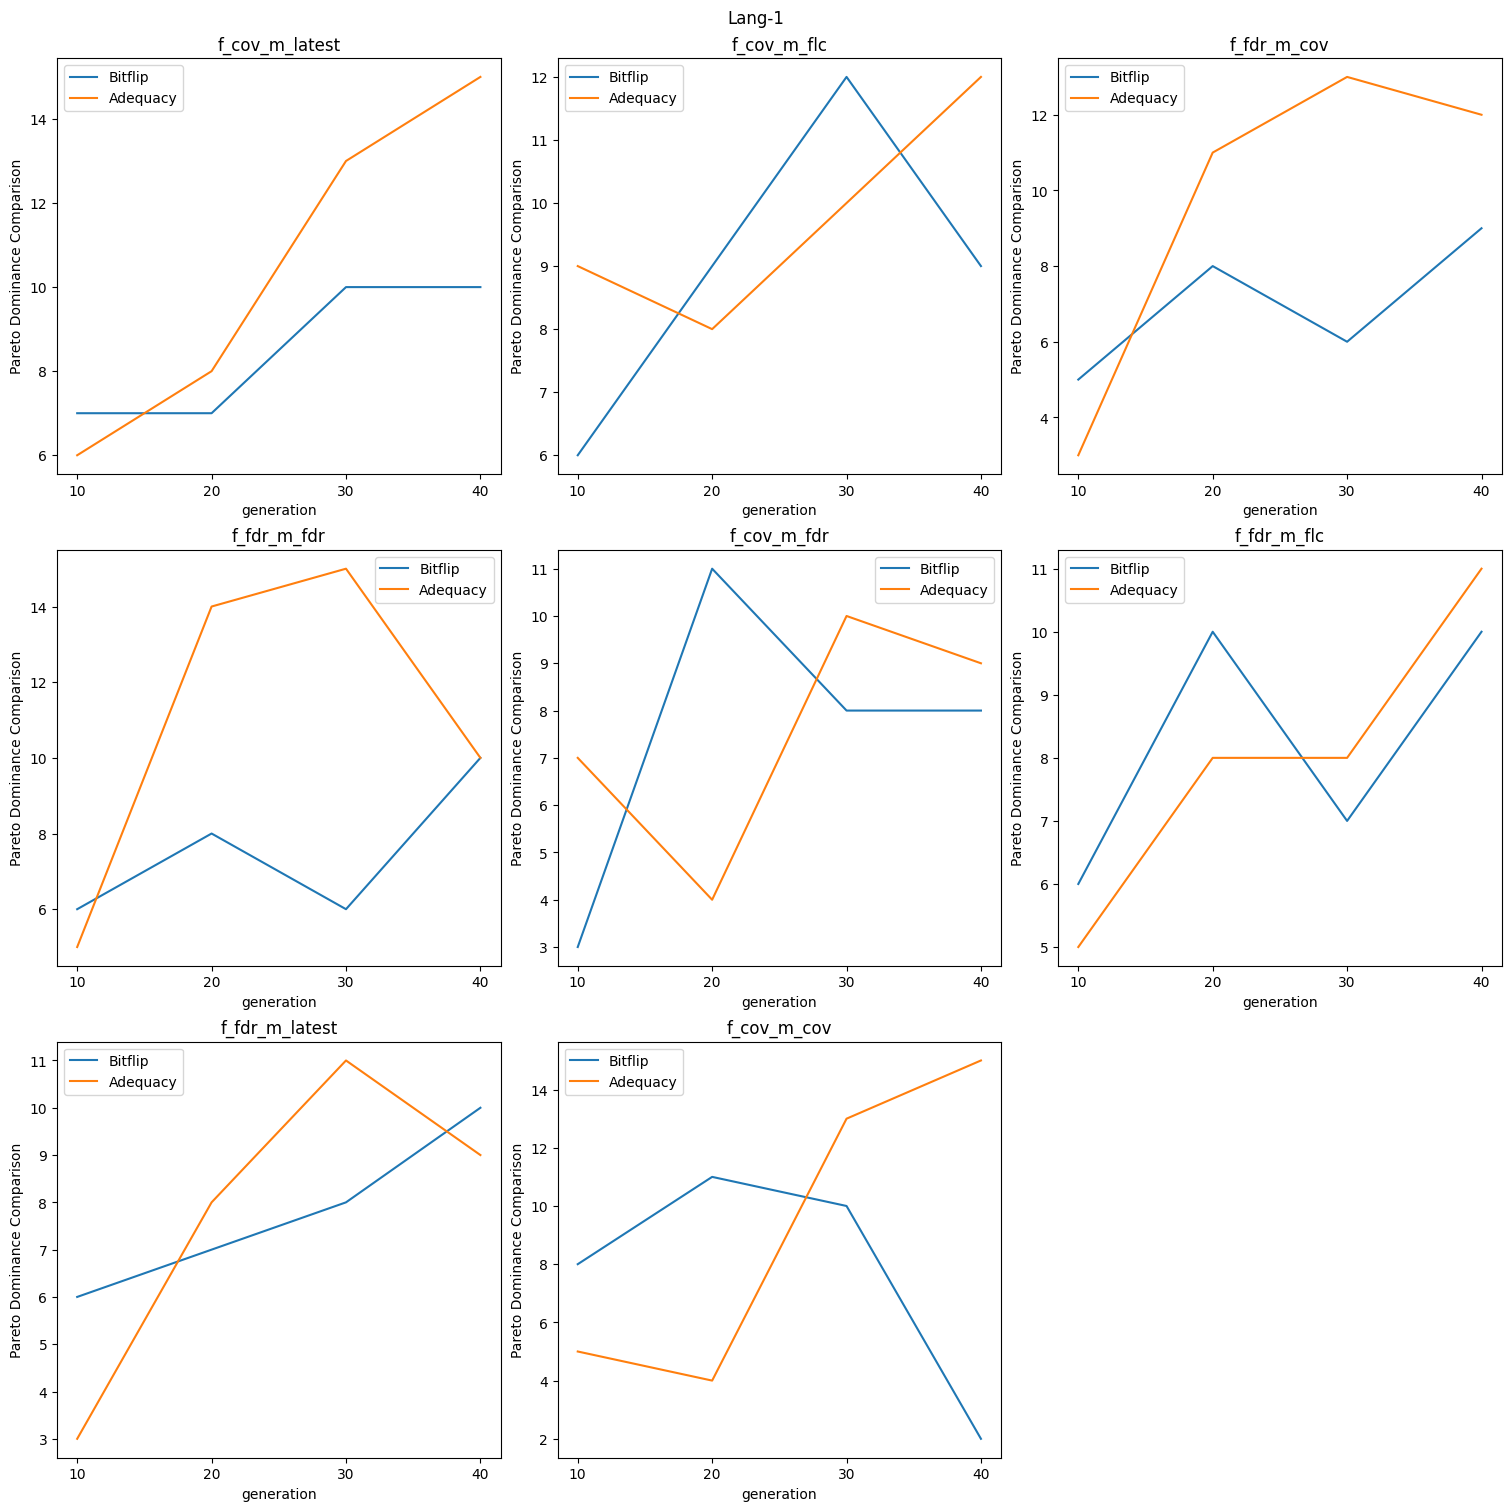

Time_1.pkl
f_cov_m_latest
[9, 9, 15, 3]
[4, 5, 2, 19]
f_cov_m_flc
[9, 11, 14, 9]
[0, 5, 2, 16]
f_fdr_m_cov
[5, 11, 19, 7]
[4, 10, 4, 22]
f_fdr_m_fdr
[5, 10, 14, 8]
[5, 13, 9, 15]
f_cov_m_fdr
[9, 10, 15, 5]
[2, 4, 3, 21]
f_fdr_m_flc
[5, 9, 10, 16]
[4, 10, 12, 17]
f_fdr_m_latest
[6, 10, 5, 11]
[1, 9, 14, 12]
f_cov_m_cov
[9, 6, 14, 6]
[4, 7, 11, 15]


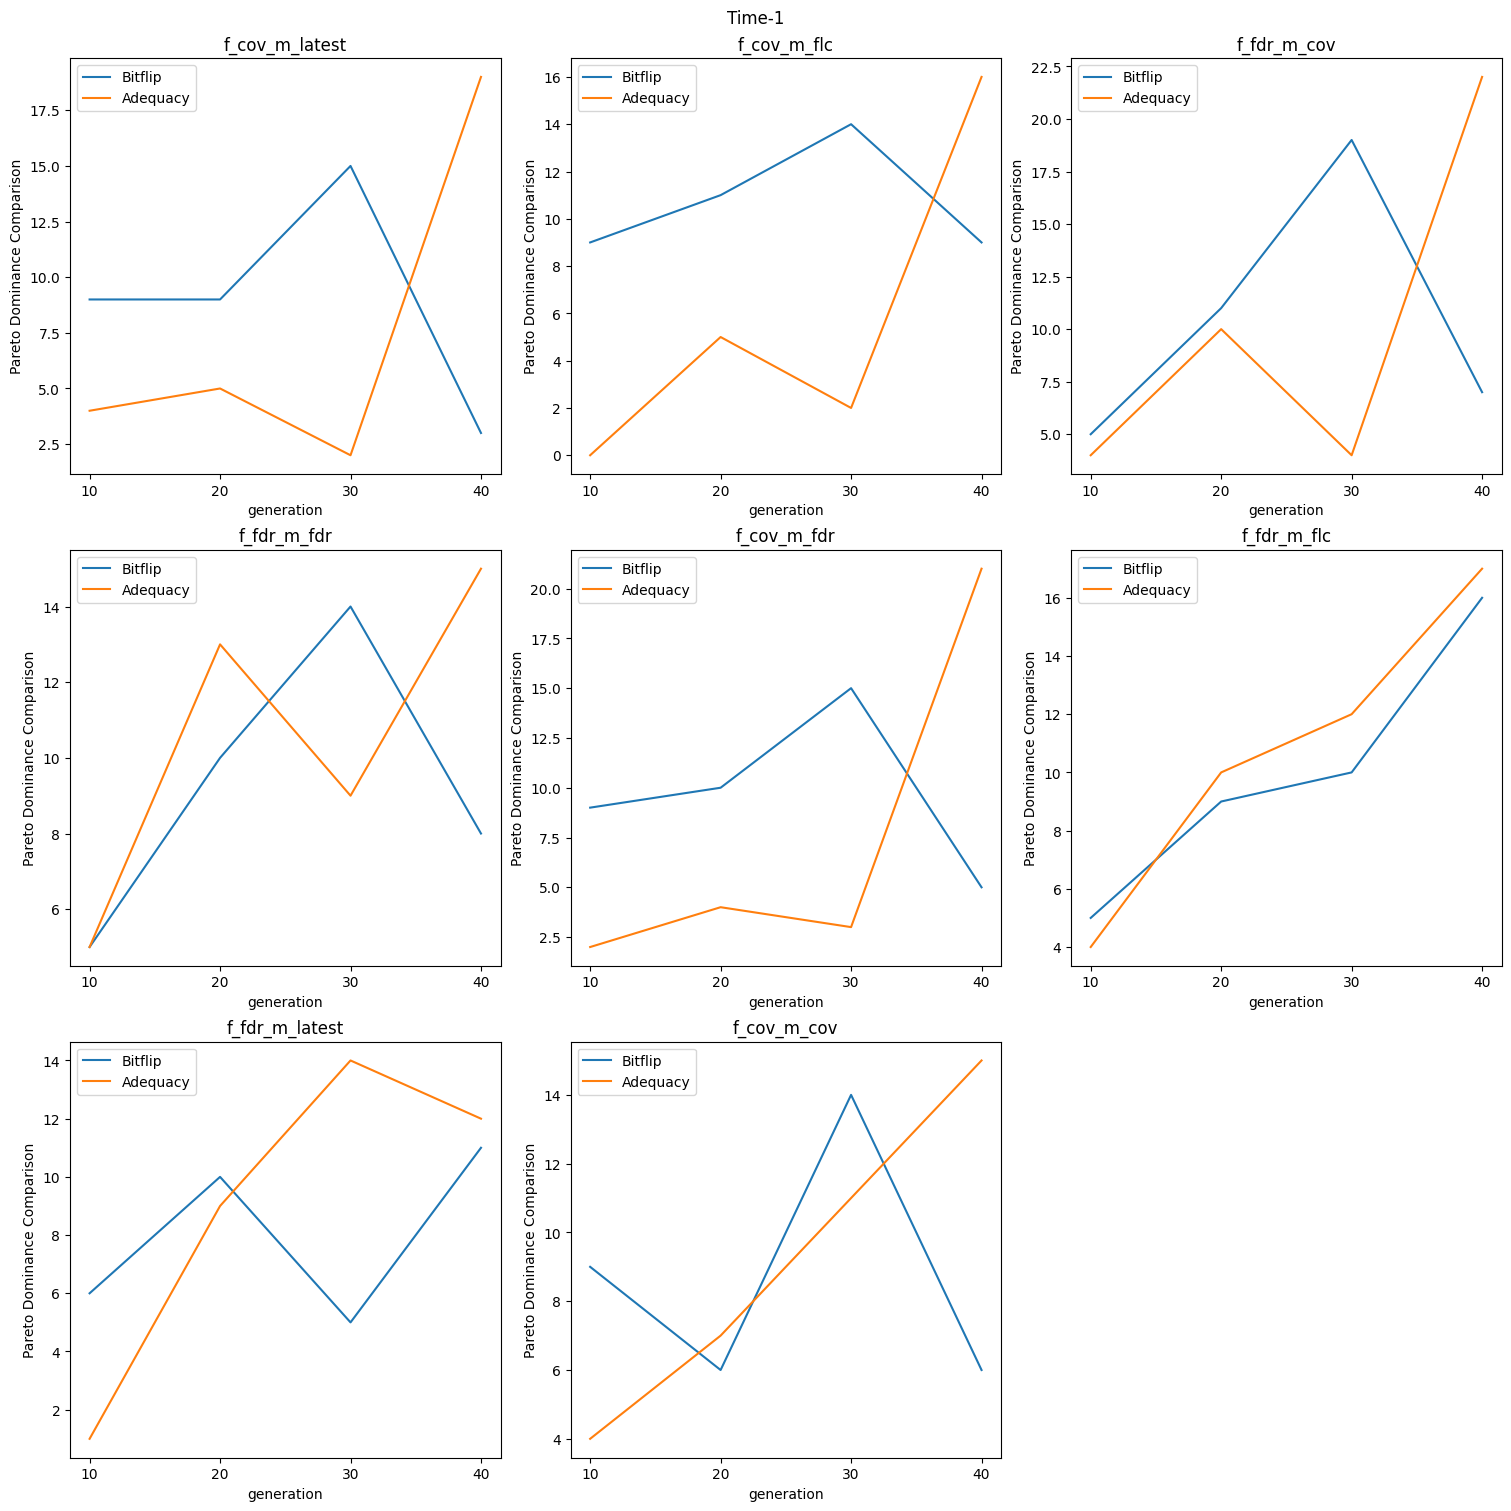

JacksonCore_26.pkl
f_cov_m_latest
[4, 10, 7, 7]
[5, 3, 9, 15]
f_cov_m_flc
[4, 14, 12, 11]
[3, 5, 8, 10]
f_fdr_m_cov
[6, 4, 3, 7]
[8, 14, 13, 17]
f_fdr_m_fdr
[8, 8, 3, 8]
[5, 11, 14, 15]
f_cov_m_fdr
[8, 14, 10, 13]
[6, 2, 7, 9]
f_fdr_m_flc
[3, 8, 6, 4]
[7, 6, 11, 19]
f_fdr_m_latest
[3, 8, 1, 9]
[7, 12, 9, 13]
f_cov_m_cov
[5, 11, 6, 15]
[7, 4, 11, 4]


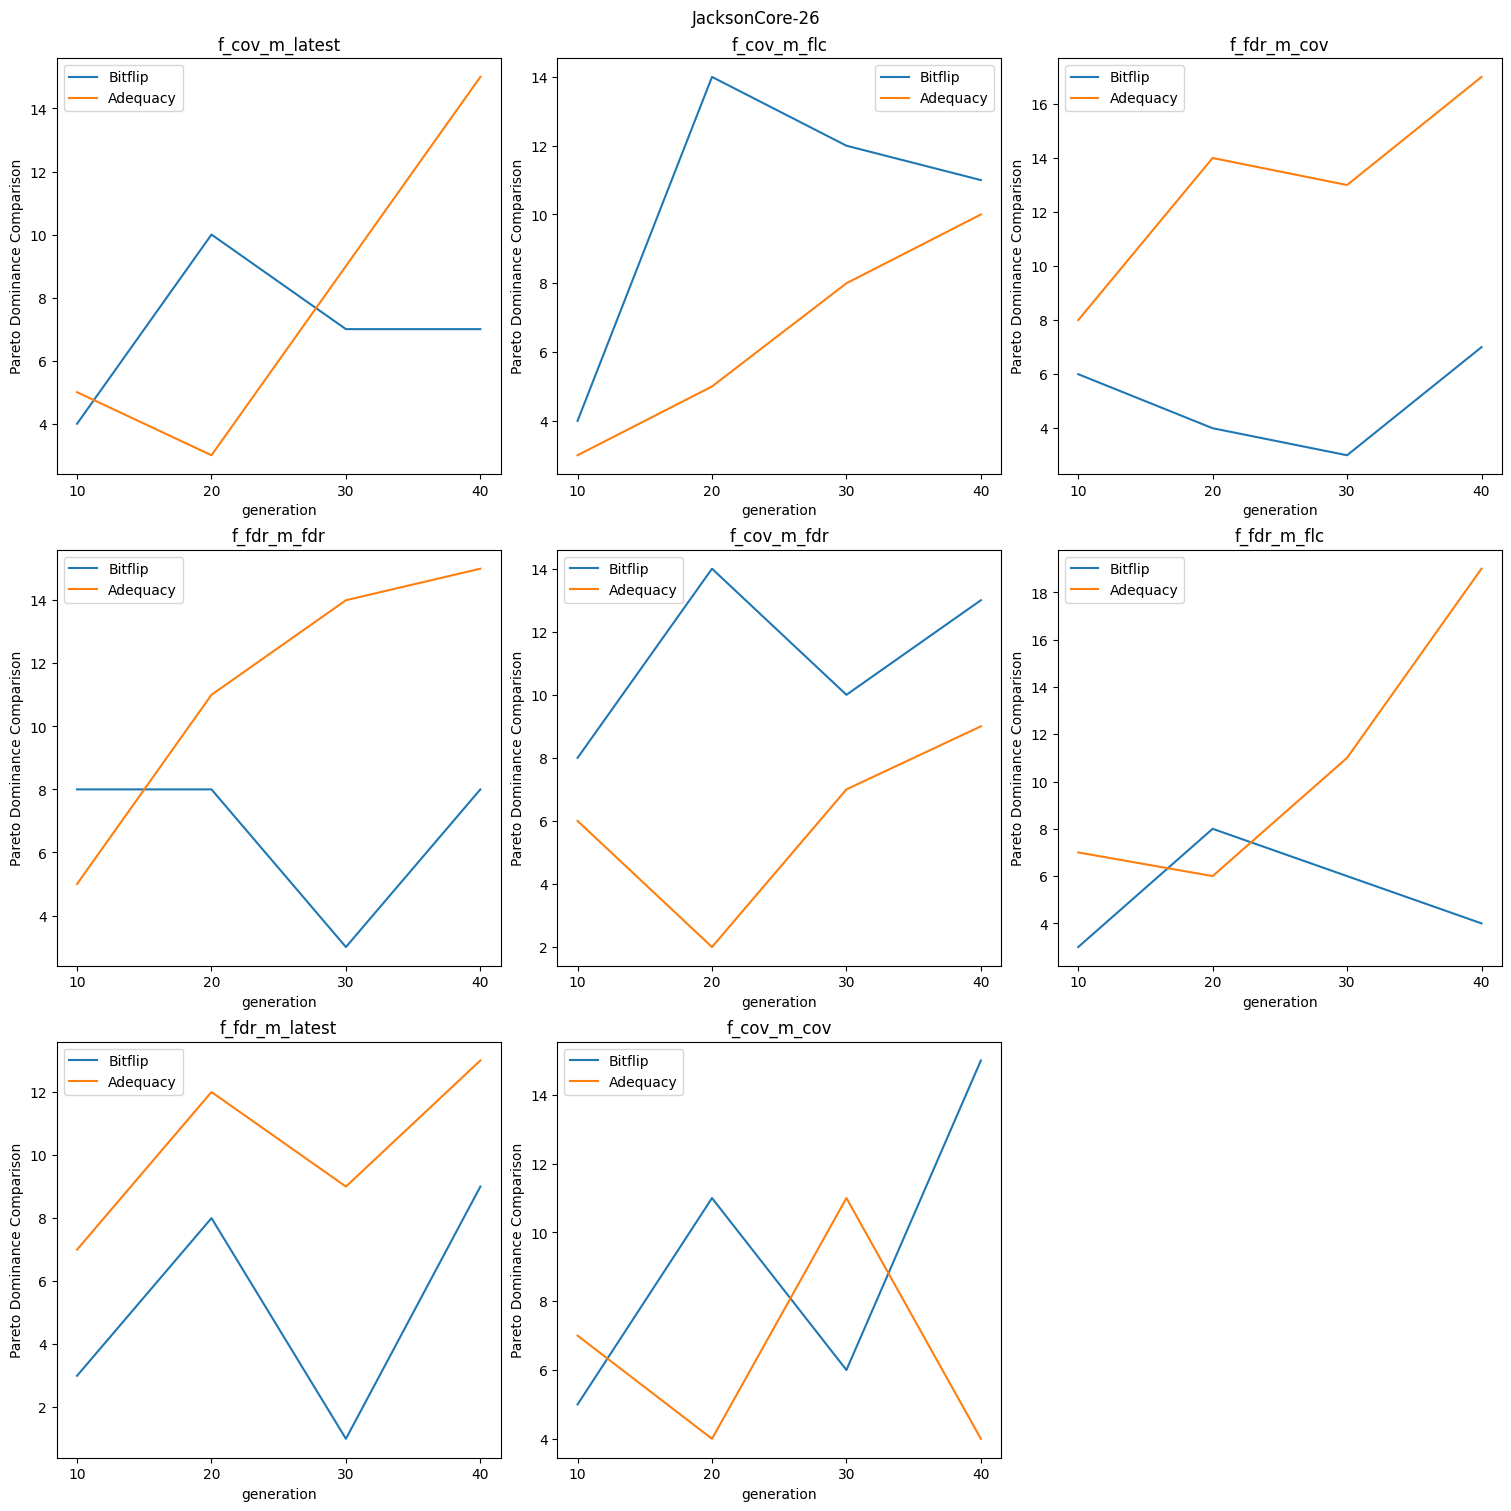

Chart_1.pkl
Csv_16.pkl
f_cov_m_latest
[6, 3, 8, 10]
[5, 6, 9, 9]
f_cov_m_flc
[5, 3, 7, 10]
[7, 8, 8, 14]
f_fdr_m_cov
[6, 12, 4, 12]
[6, 1, 9, 10]
f_fdr_m_fdr
[7, 10, 3, 9]
[7, 6, 12, 17]
f_cov_m_fdr
[5, 4, 2, 13]
[6, 8, 12, 10]
f_fdr_m_flc
[7, 7, 7, 9]
[4, 7, 4, 11]
f_fdr_m_latest
[4, 10, 6, 12]
[7, 6, 6, 12]
f_cov_m_cov
[9, 5, 6, 10]
[2, 6, 12, 9]


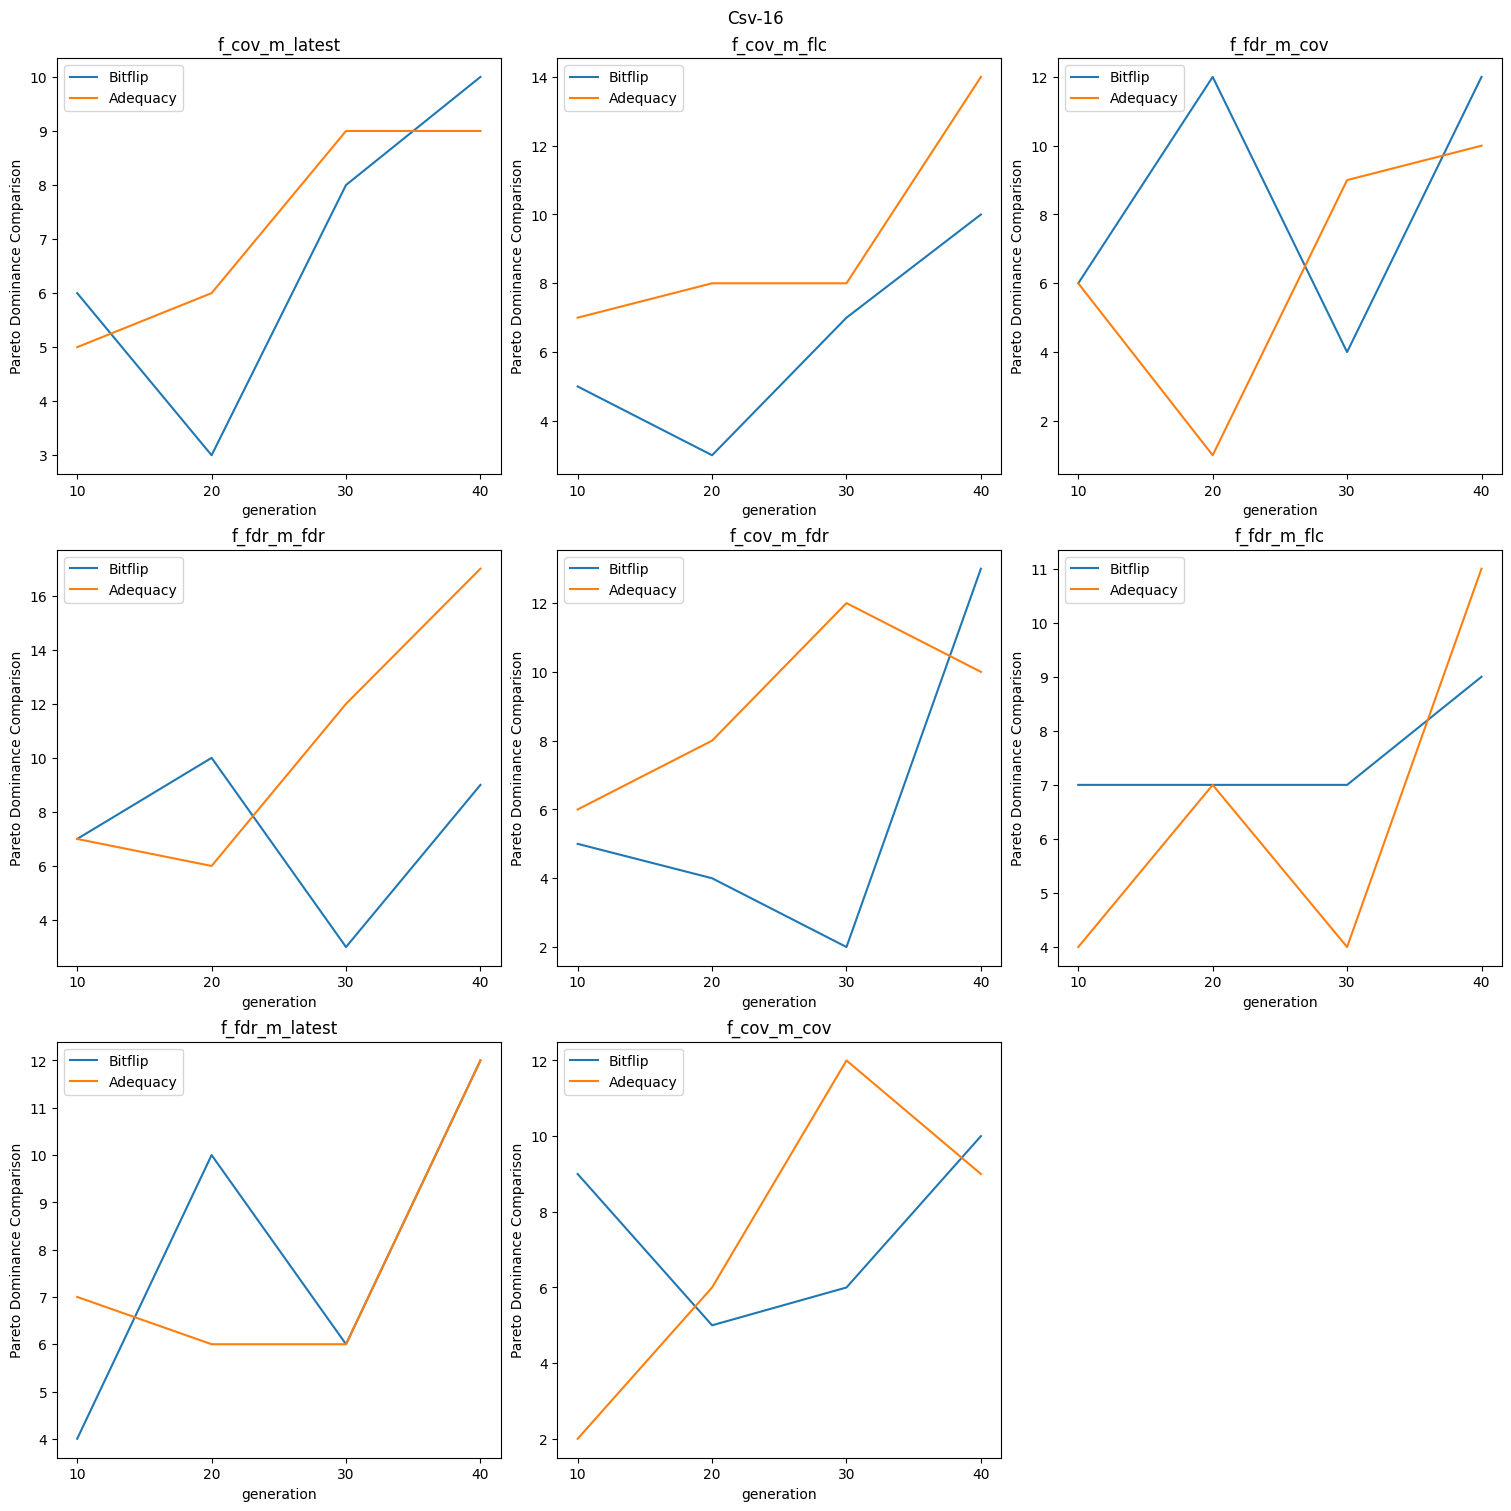

In [8]:
gx = ['10', '20', '30', '40']
for target in os.listdir('./data/merged_data/'):
    print(target)
    pid, vid = os.path.splitext(target)[0].split('_')
    # There is no data for Chart_1 ####
    if pid == "Chart":
        continue
    #####################
    plt.figure(figsize=(15, 15), constrained_layout=True)
    result_dir = f"./data/experiment_result/10_generation/"
    for j, type in enumerate(os.listdir(result_dir)):
        print(type)
        ax = plt.subplot(3, 3, j+1)
        pdc_result_adeq = []
        pdc_result_bitflip = []
        for generation in gx:
            with open(f'./data/experiment_result/{generation}_generation/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
                bitflip = pickle.load(f)
            with open(f'./data/experiment_result/{generation}_generation/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
                adeq = pickle.load(f)
            with open(f'./data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
                merged_data = pickle.load(f)
            with open(f"./data/killmap/{pid}-{vid}_fdr.json", "rb") as f:
                killmap = json.load(f)[f"{pid}_{vid}"]
            with open(f"./data/all_class_mutation/{pid}-{vid}_fdr.json", "rb") as f:
                fdr = json.load(f)[f"{pid}_{vid}"]

            
            total_mutant = fdr[list(fdr.keys())[0]]["mutants-generated"]
            bitflip_result = []
            adeq_result = []
            for i, sol in enumerate(bitflip.X):
                bitflip_kill = set()
                for test in merged_data.index[sol]:
                    if test in killmap:
                        bitflip_kill = bitflip_kill.union(set(killmap[test]))
                mut_score = len(bitflip_kill) / total_mutant
                bitflip_result.append([bitflip.F[i][0], mut_score])
            
            for i, sol in enumerate(adeq.X):
                adeq_kill = set()
                for test in merged_data.index[sol]:
                    if test in killmap:
                        adeq_kill = adeq_kill.union(set(killmap[test]))
                mut_score = len(adeq_kill) / total_mutant
                adeq_result.append([adeq.F[i][0], mut_score])
            
            combined_set = bitflip_result + adeq_result
            pareto_frontier = []
            #for point in combined_set:
            #   if all(dominates(point, other_point) for other_point in combined_set if other_point != point):
            #        pareto_frontier.append(point)
            for point in combined_set:
                if not any(dominates(other_point, point) for other_point in combined_set):
                    pareto_frontier.append(point)

            bitflip_contribution = sum(1 for point in pareto_frontier if point in bitflip_result)
            adeq_contribution = sum(1 for point in pareto_frontier if point in adeq_result)

            pdc_result_bitflip.append(bitflip_contribution)
            pdc_result_adeq.append(adeq_contribution)
            
        
        plt.plot(gx, pdc_result_bitflip, label = "Bitflip")
        plt.plot(gx, pdc_result_adeq, label = "Adequacy")
        plt.xlabel("generation")
        plt.ylabel("Pareto Dominance Comparison")
        plt.title(type)
        plt.legend()
    

    
        print(pdc_result_bitflip)
        print(pdc_result_adeq)
    plt.suptitle(f"{pid}-{vid}")
    plt.show()

### Hypervolume Calculation

In [26]:
def calculate_hypervolume(front, reference):
    hypervolume = 0
    for point in front:
        volume = abs((reference[0]-point[0])*(reference[1]-point[1]))
        hypervolume += volume
    return hypervolume

JxPath_22.pkl
f_cov_m_latest
[0.6646657881377884, 0.6956035656565663, 1.2591807005957012, 1.4366768433048438]
[0.22738650893550905, 0.5101649401709406, 1.471791284123285, 1.4472001017871021]
f_cov_m_flc
[0.44505749287749263, 1.1964696879046879, 1.1731560958300953, 2.39354163998964]
[0.2884136542346542, 0.8086131139601138, 0.8610402732452731, 2.774696113183113]
f_fdr_m_cov
[0.4937420160580165, 1.0432505791245799, 2.181050521367521, 2.980053371406371]
[0.5267084110334114, 1.699507345765347, 2.8946567904687903, 1.8667757228697228]
f_fdr_m_fdr
[0.4937420160580165, 1.0432505791245799, 2.5420521313131323, 2.7696012830872836]
[0.260329700854701, 0.8903866542346548, 4.051242829577831, 3.051332131313132]
f_cov_m_fdr
[0.5966728111888109, 0.6522872362082361, 1.6001673623413626, 1.3467504993524995]
[0.8585433444703443, 0.5764483763273761, 0.9676253462833467, 1.8768492196322197]
f_fdr_m_flc
[0.4241203822843826, 0.9552232496762502, 2.5420521313131323, 2.980053371406371]
[0.17211061512561535, 1.70660

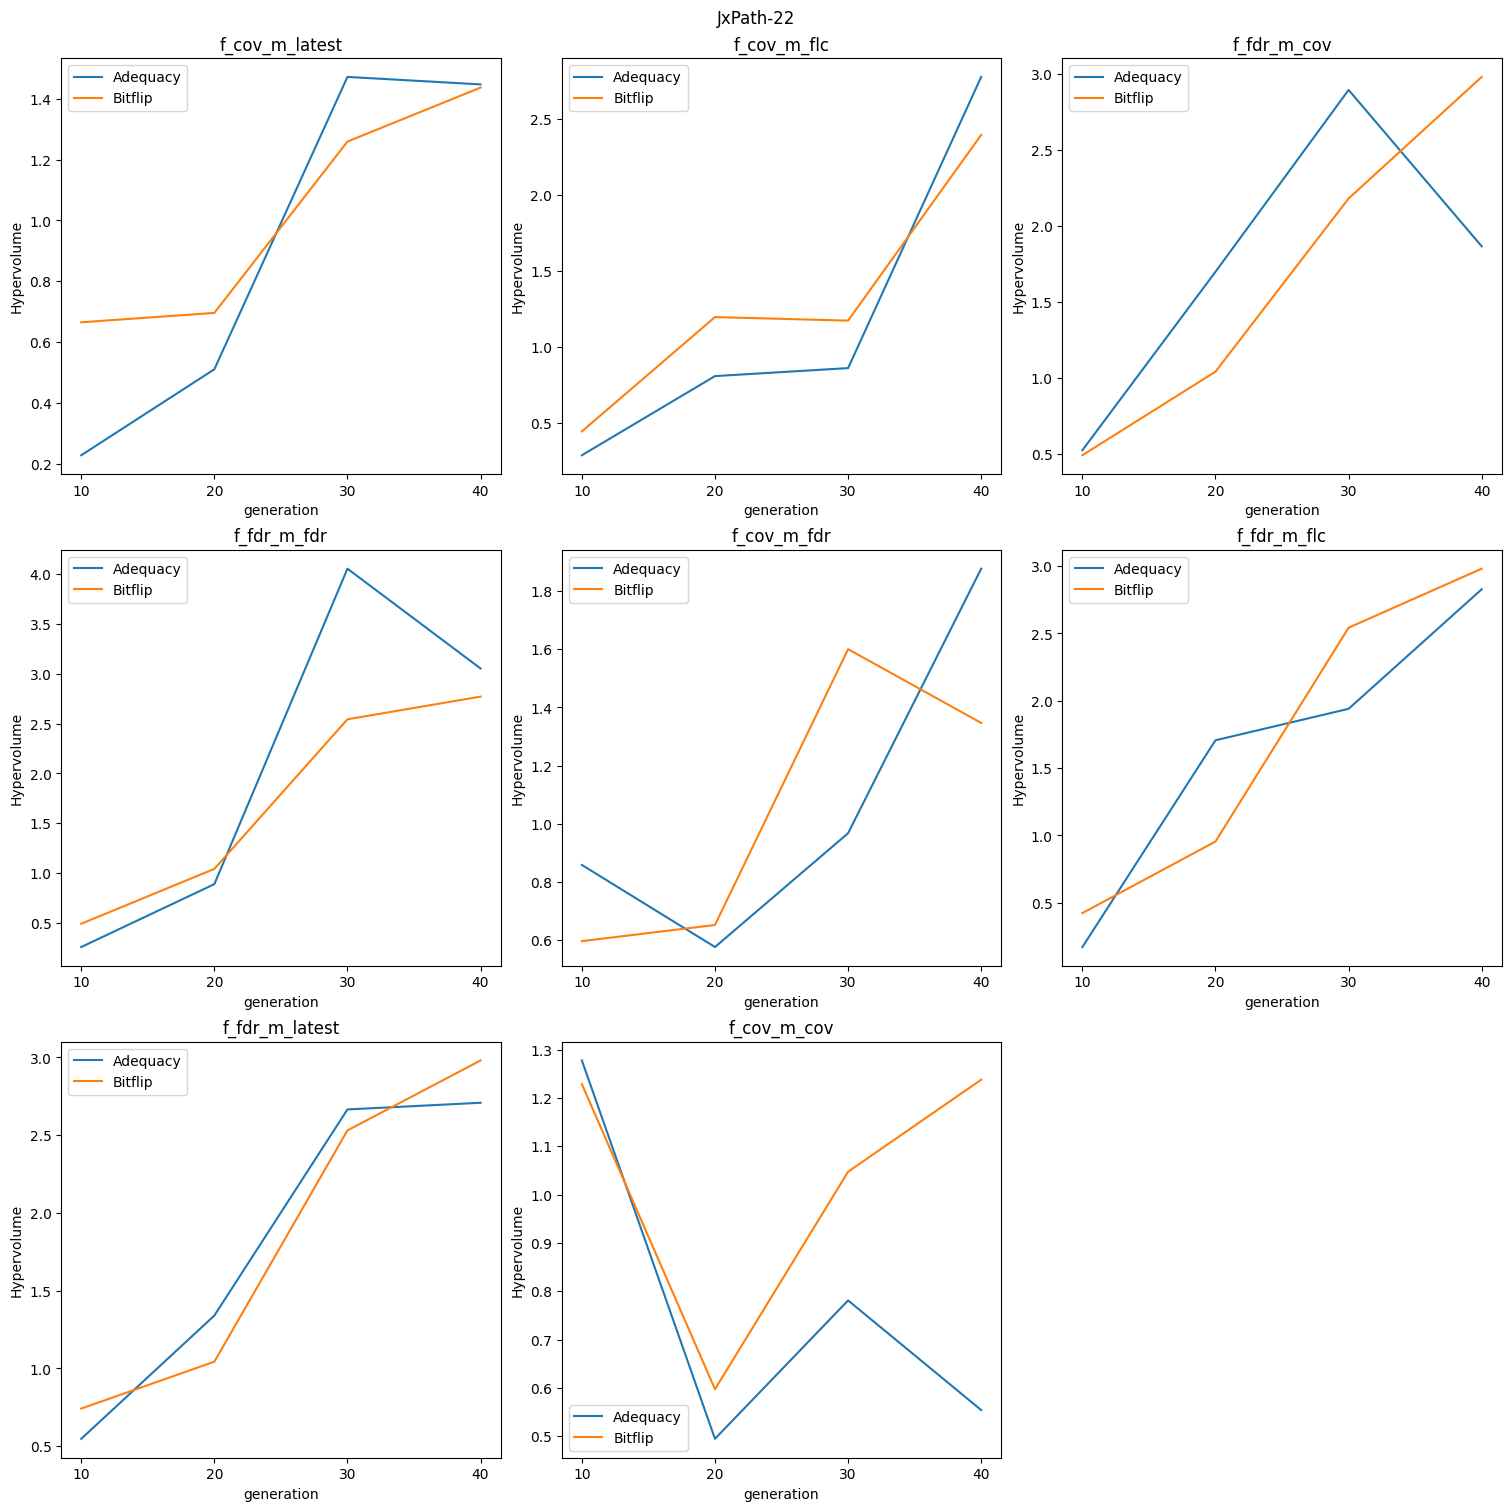

Cli_40.pkl
f_cov_m_latest
[0.06949843028624192, 0.12110260080024622, 0.06288034749153584, 0.15885189750692522]
[0.11004081255771006, 0.10596001846722068, 0.06777818220991072, 0.20877878855032317]
f_cov_m_flc
[0.08108430286241919, 0.12713522622345336, 0.07446843613419511, 0.15885189750692522]
[0.12716666666666665, 0.10441588180978763, 0.07820971252693135, 0.15879755124653738]
f_fdr_m_cov
[0.12904126438904276, 0.21127905047706988, 0.22611670975684822, 0.1751961163434903]
[0.10711140412434592, 0.1340711104955371, 0.14835801538935056, 0.07927575069252078]
f_fdr_m_fdr
[0.05928210649430593, 0.1673847445367805, 0.2294075869498307, 0.35872137950138505]
[0.039985412126808235, 0.14367365620190825, 0.18339256694367495, 0.12156370452446907]
f_cov_m_fdr
[0.07556722068328715, 0.12713522622345336, 0.06416791289627577, 0.15885189750692522]
[0.10642980917205293, 0.11776417359187444, 0.05828382548476454, 0.13956330101569714]
f_fdr_m_flc
[0.17802327423822717, 0.1589435318559557, 0.10435425361649739, 0.13

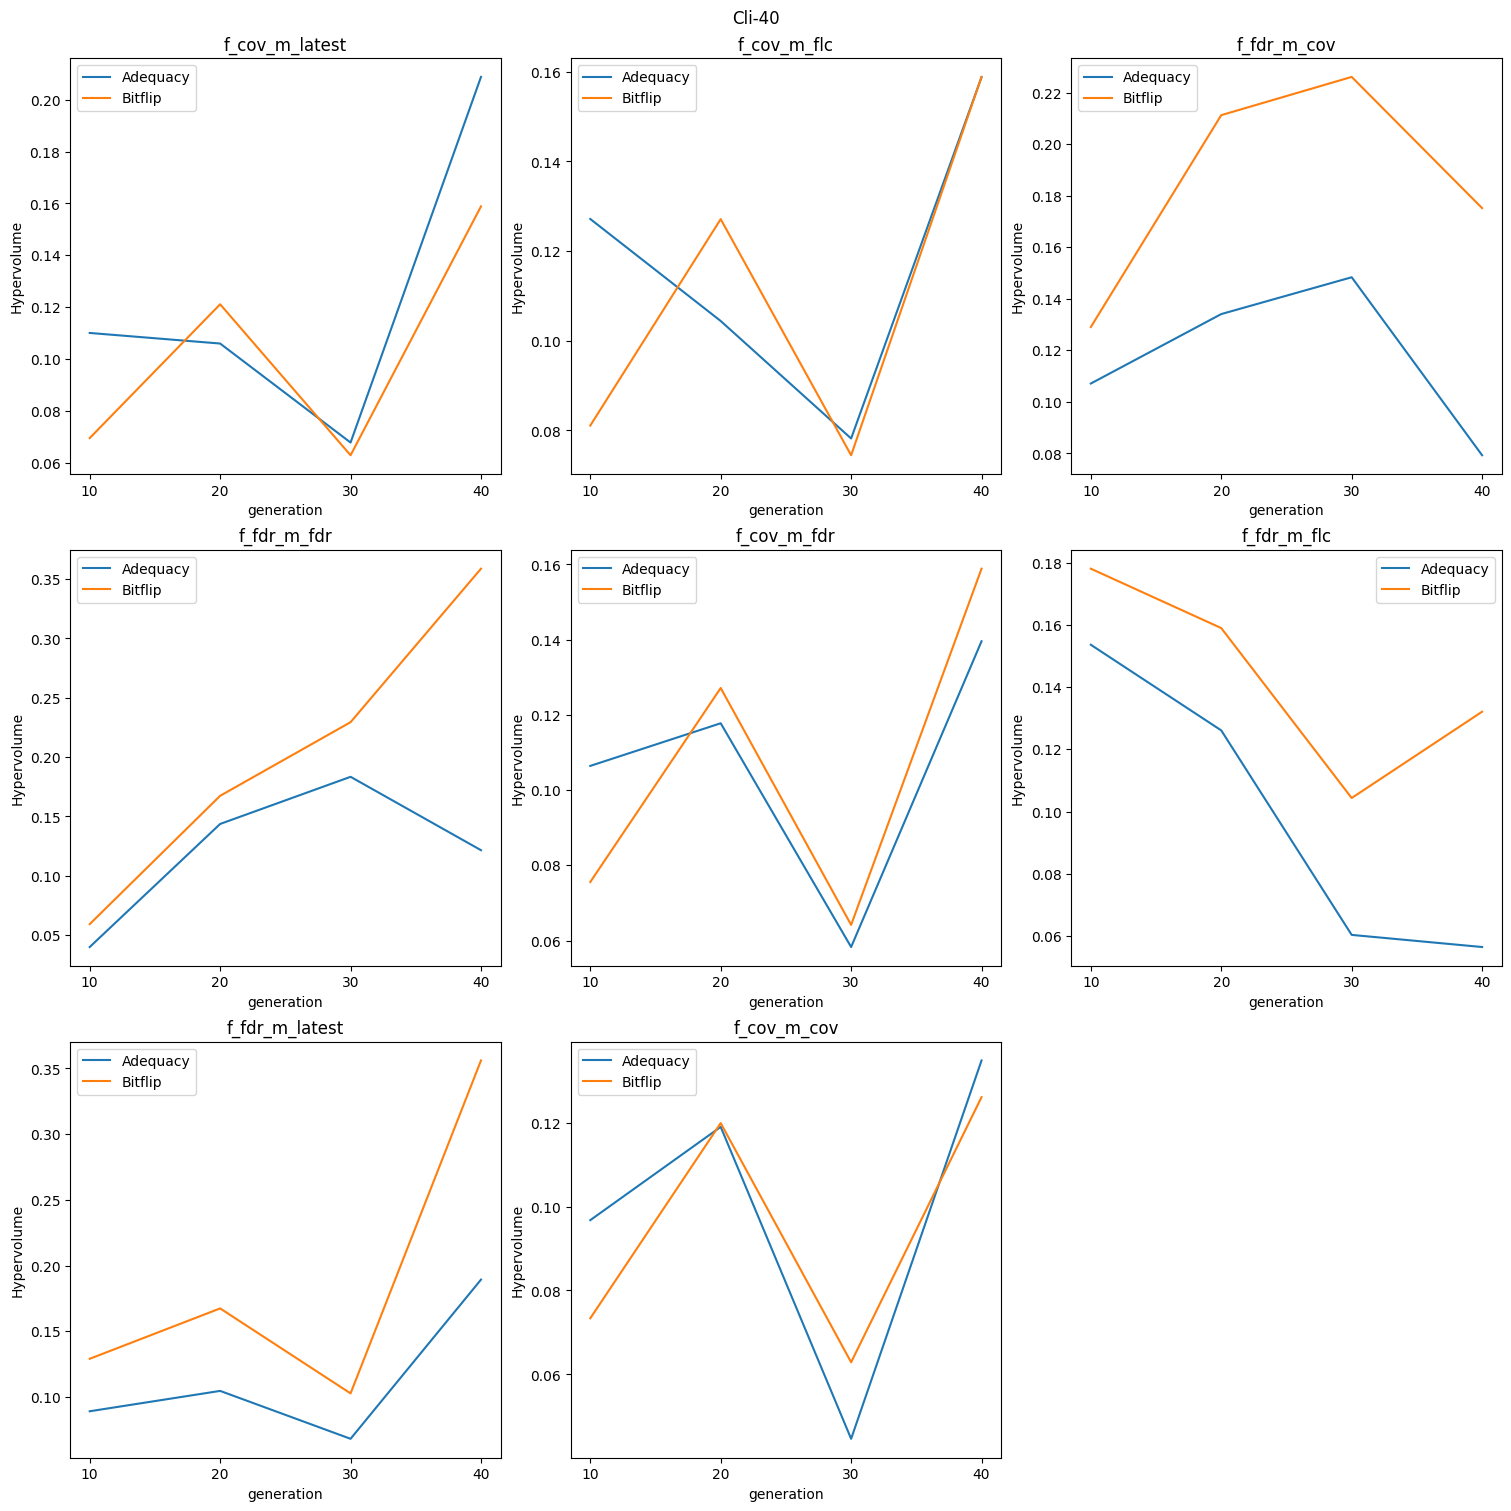

Lang_1.pkl
f_cov_m_latest
[2.3957458288522697, 1.0019690993918862, 2.1561278317233037, 0.588141196113088]
[0.3466201011145734, 1.6485655549703147, 0.6617799251535409, 2.2144202790958287]
f_cov_m_flc
[2.2712325483701137, 1.004706306190684, 1.9193951531030857, 0.4347592984690746]
[1.885447376826218, 0.8319054265943886, 1.4392214689408933, 1.0626484895819492]
f_fdr_m_cov
[0.9590212628669998, 2.114424600203696, 1.904998006188945, 1.4209028301322324]
[0.5457047379702907, 0.6662245007490931, 2.263202849771537, 2.3800839173527915]
f_fdr_m_fdr
[1.0227064993869843, 2.117757837965632, 2.0035384582260956, 1.3497279431055131]
[0.22855315503331036, 1.0321795217974592, 2.6336455795160862, 1.5752050942751077]
f_cov_m_fdr
[2.3957458288522697, 1.0076768129618183, 1.715777563539822, 0.4229466223100895]
[0.9522166562240989, 0.9072775864552762, 1.2800789309198677, 1.0694382751012943]
f_fdr_m_flc
[1.0227064993869839, 2.106263914648611, 1.905732381844387, 1.3462661369002227]
[1.411803430089386, 2.2275951900

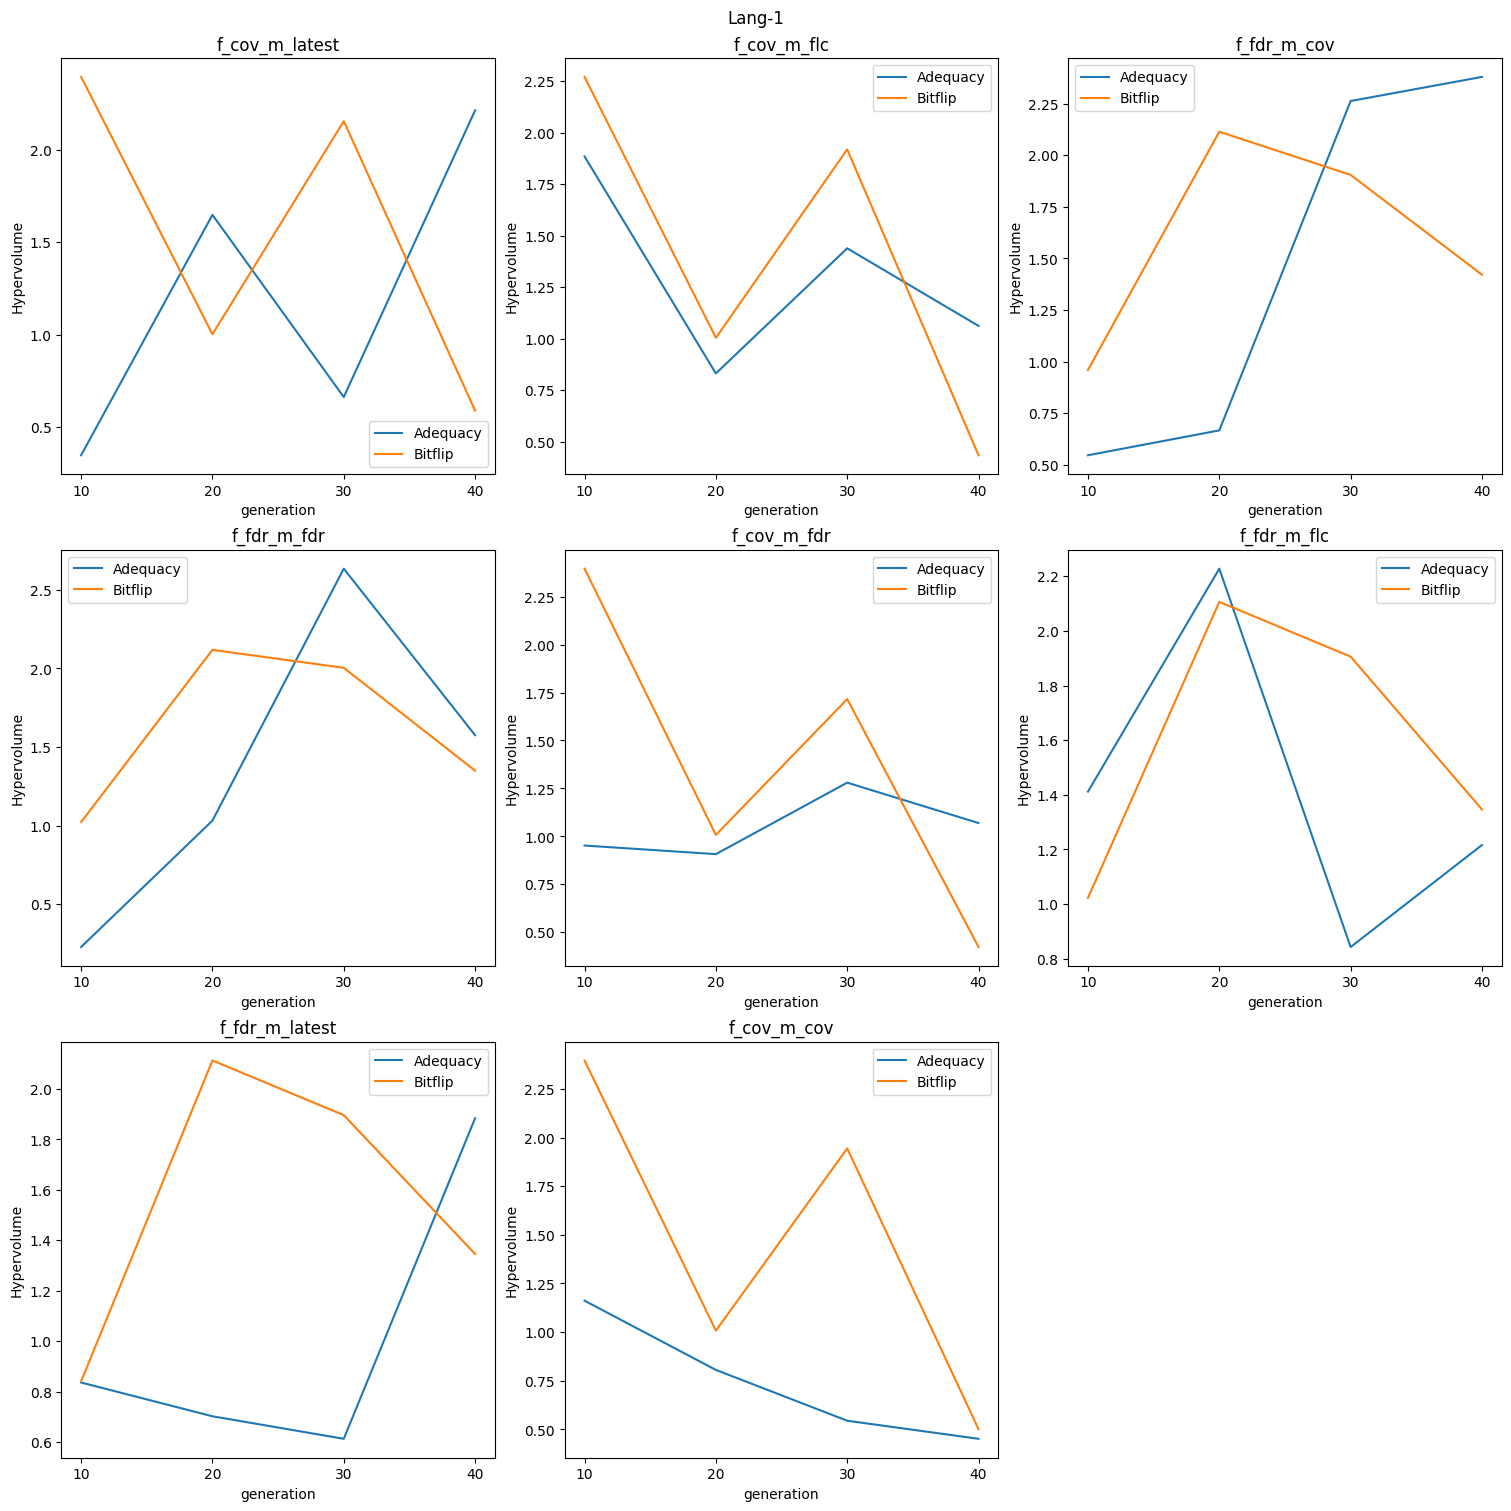

Time_1.pkl
f_cov_m_latest
[0.6607011583650094, 2.4348480146615987, 1.893400975514637, 2.1736773641704117]
[0.2122827749419952, 0.918885819173619, 2.7652176954632974, 2.920523596978823]
f_cov_m_flc
[0.5133693464481415, 1.3918405245594119, 1.9389980199930885, 2.5532367263661935]
[0.2795261233647628, 1.2023461188231228, 2.1597894608283554, 2.5237696729031938]
f_fdr_m_cov
[0.48077386779878545, 2.5788539546823315, 3.9259136902799026, 2.4758456809004294]
[0.5113508210988792, 1.3078588797946389, 3.5160070469467346, 3.4304588437083487]
f_fdr_m_fdr
[0.5431013237893074, 2.2602396518240604, 3.6286675676556257, 2.4758456809004294]
[0.7502349548797947, 1.9485508953941846, 2.3688171569334058, 1.95871256987708]
f_cov_m_fdr
[1.1195152771387675, 1.4621623220121442, 1.2013094520906353, 2.051751979661352]
[0.785237078491386, 1.3563869005282128, 0.7053495899195341, 2.5961376757664025]
f_fdr_m_flc
[0.5317899293083874, 2.455701582761514, 4.128625139359236, 2.4758456809004294]
[0.7678781867008939, 1.15605374

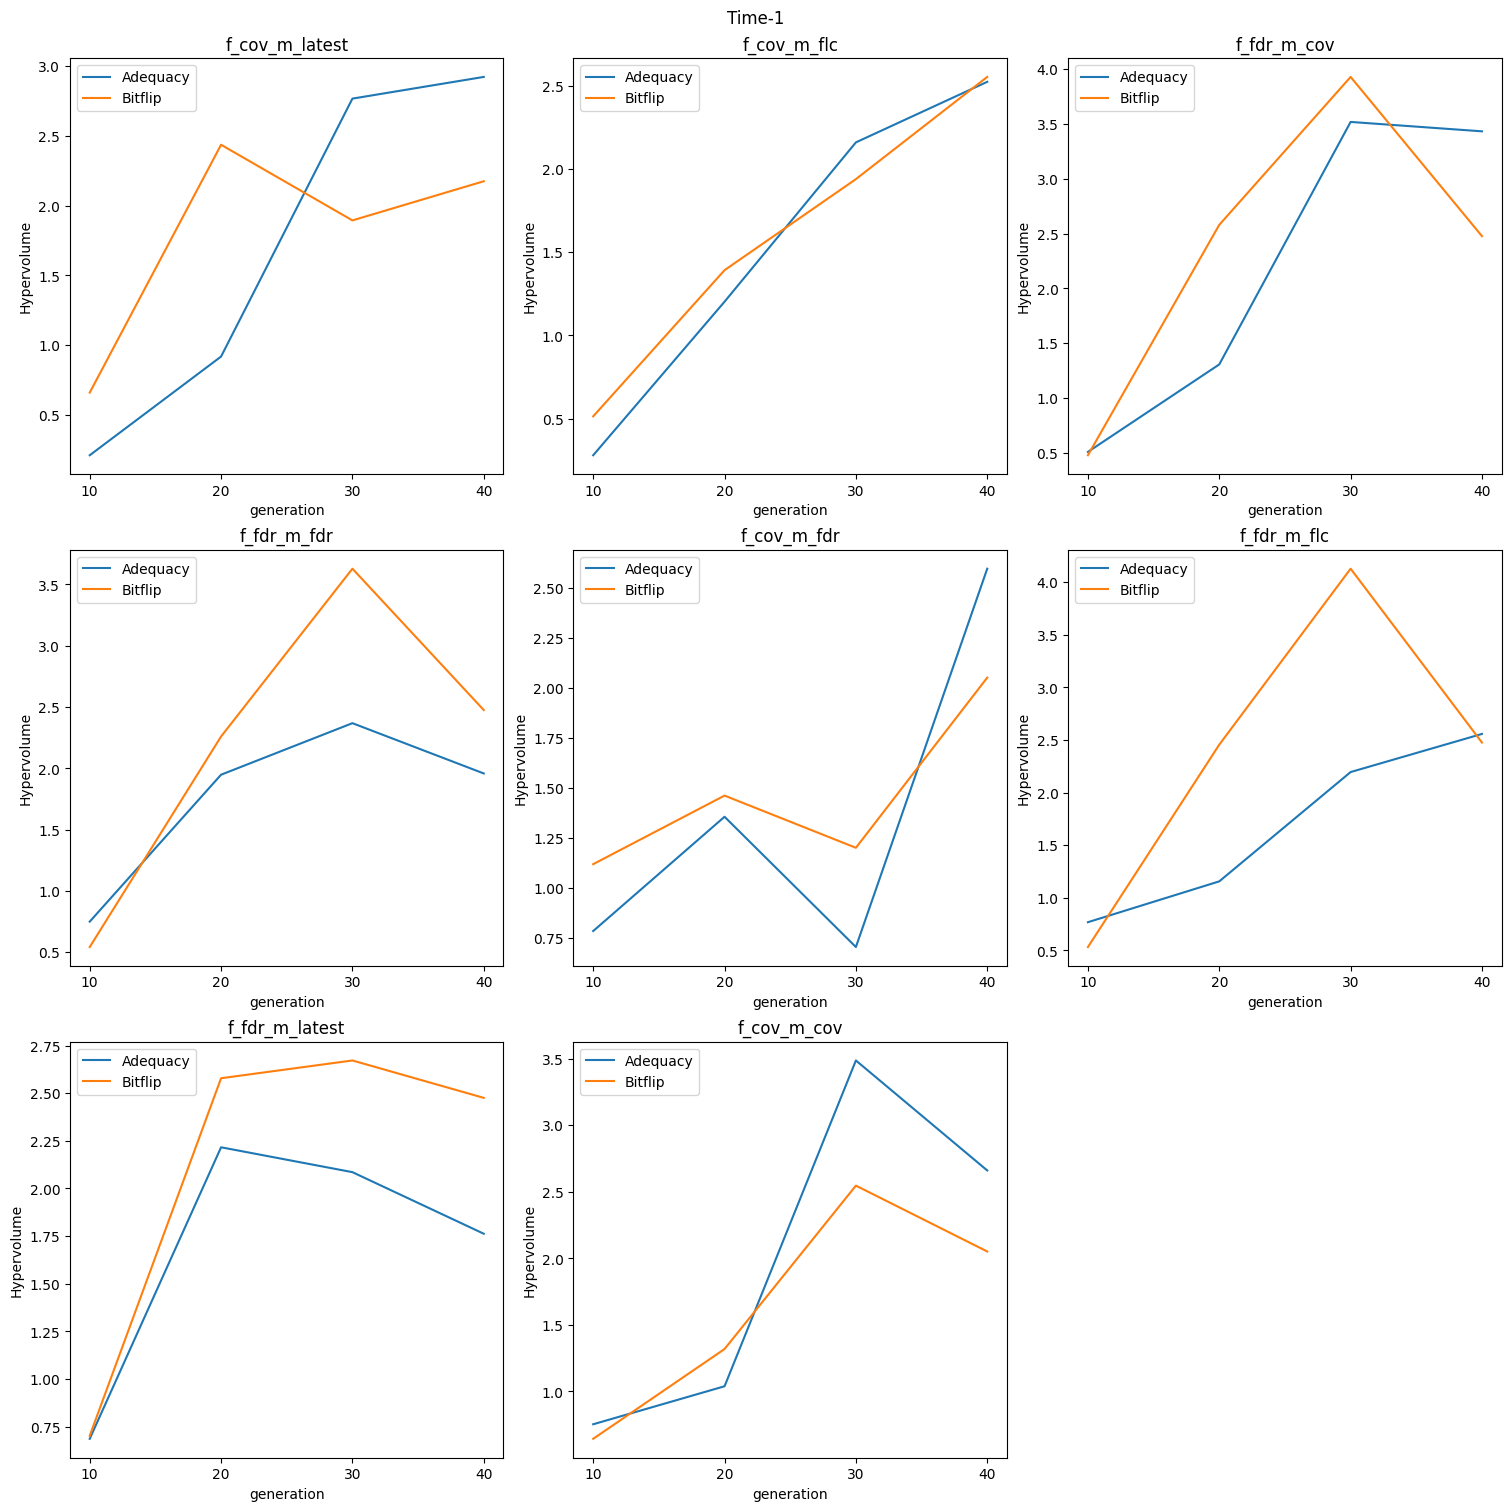

JacksonCore_26.pkl
f_cov_m_latest
[1.3385116458046316, 5.790113964770716, 5.380435240963067, 4.545396431214327]
[2.6160570398871617, 3.375735852063242, 6.19287620370006, 4.774876278160466]
f_cov_m_flc
[1.3385116458046316, 5.484420646395066, 5.714746505937152, 4.461526663124055]
[1.3010621424916358, 4.419392479629995, 5.375960856852326, 2.984332016860198]
f_fdr_m_cov
[1.7377164583743354, 6.218878958079119, 8.951807253230994, 10.496267918848]
[1.924249341993045, 4.503052734763497, 8.271533200944695, 6.028490610050516]
f_fdr_m_fdr
[1.4616247661877586, 3.582605244505676, 9.429416130223712, 12.193596758315294]
[1.0849623743357606, 2.9499917434232112, 6.224168035426097, 9.492349036410156]
f_cov_m_fdr
[1.7714014312799324, 8.97196887771436, 5.714746505937152, 4.521179653021057]
[3.015513863084695, 4.911105899757266, 6.981469935905005, 5.287665726366201]
f_fdr_m_flc
[1.779596261562684, 5.164041770911236, 6.957253657350916, 10.496267918848]
[2.5330514184871737, 3.134909421242537, 7.1176103135209

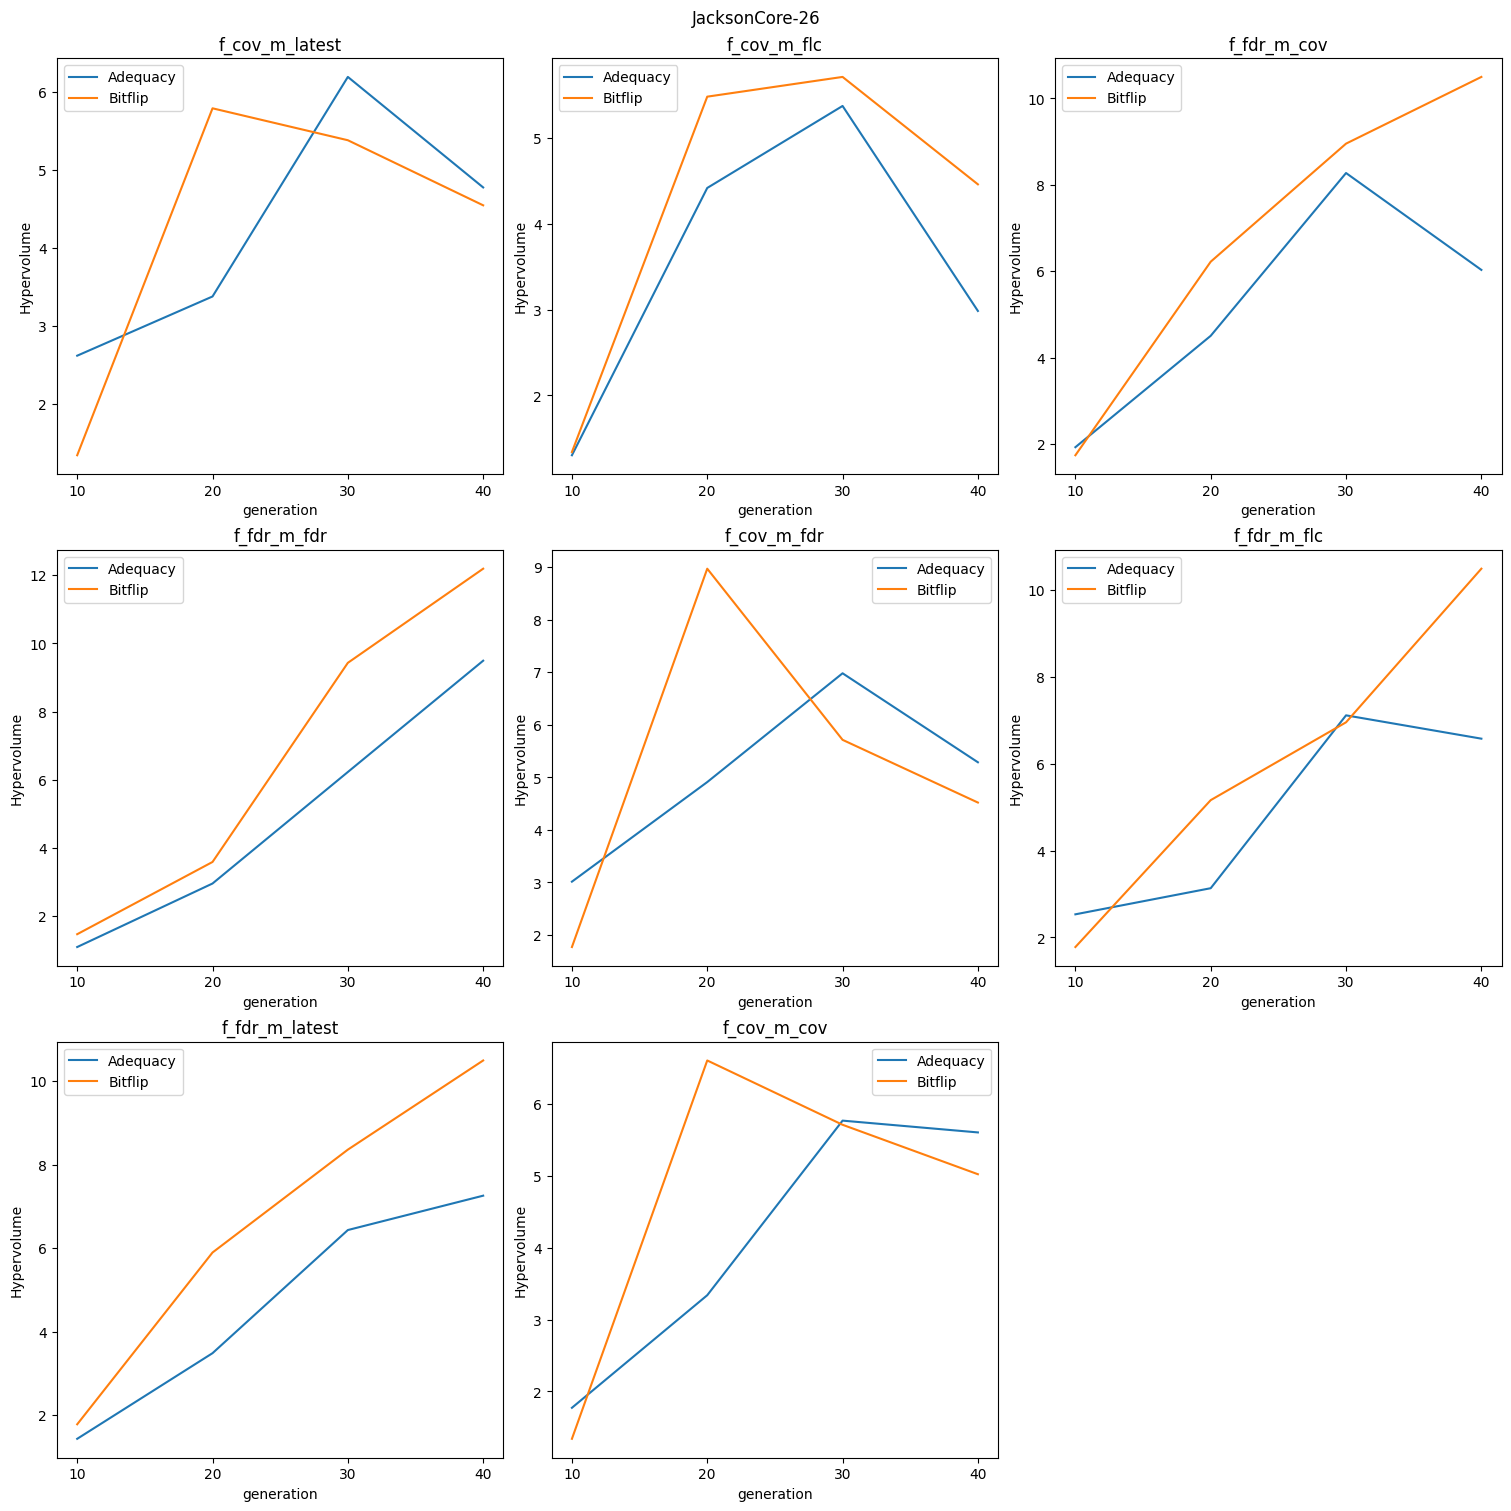

Chart_1.pkl
Csv_16.pkl
f_cov_m_latest
[3.7586182708688236, 6.912545364870316, 7.754048726614988, 8.991067978547115]
[3.121121933560476, 10.70113342732515, 7.701375696557148, 12.998009907449596]
f_cov_m_flc
[1.651450023533748, 7.103869673069834, 4.112184528999997, 10.292768666792426]
[0.7132051852197964, 6.865243562212504, 5.086961857584401, 8.824156512399547]
f_fdr_m_cov
[3.5289857921635432, 10.434762499650287, 4.45702389113356, 5.593864574776024]
[0.39934639693356044, 9.771144105241621, 6.066241486471504, 5.611088514741603]
f_fdr_m_fdr
[9.938171778558143, 10.769951761499147, 6.767195924183545, 13.553860849136166]
[7.574932159358503, 8.258870494037478, 9.905175378081022, 11.361216435767584]
f_cov_m_fdr
[4.591843821519058, 7.103869673069834, 7.070050436588898, 8.907613446363428]
[2.683109822192362, 5.869642399078268, 7.467057008480159, 8.545528318856313]
f_fdr_m_flc
[8.692351944588747, 10.218910456953468, 3.2276726284604824, 12.006674311235194]
[4.3483891254146485, 4.601398883318, 4.580

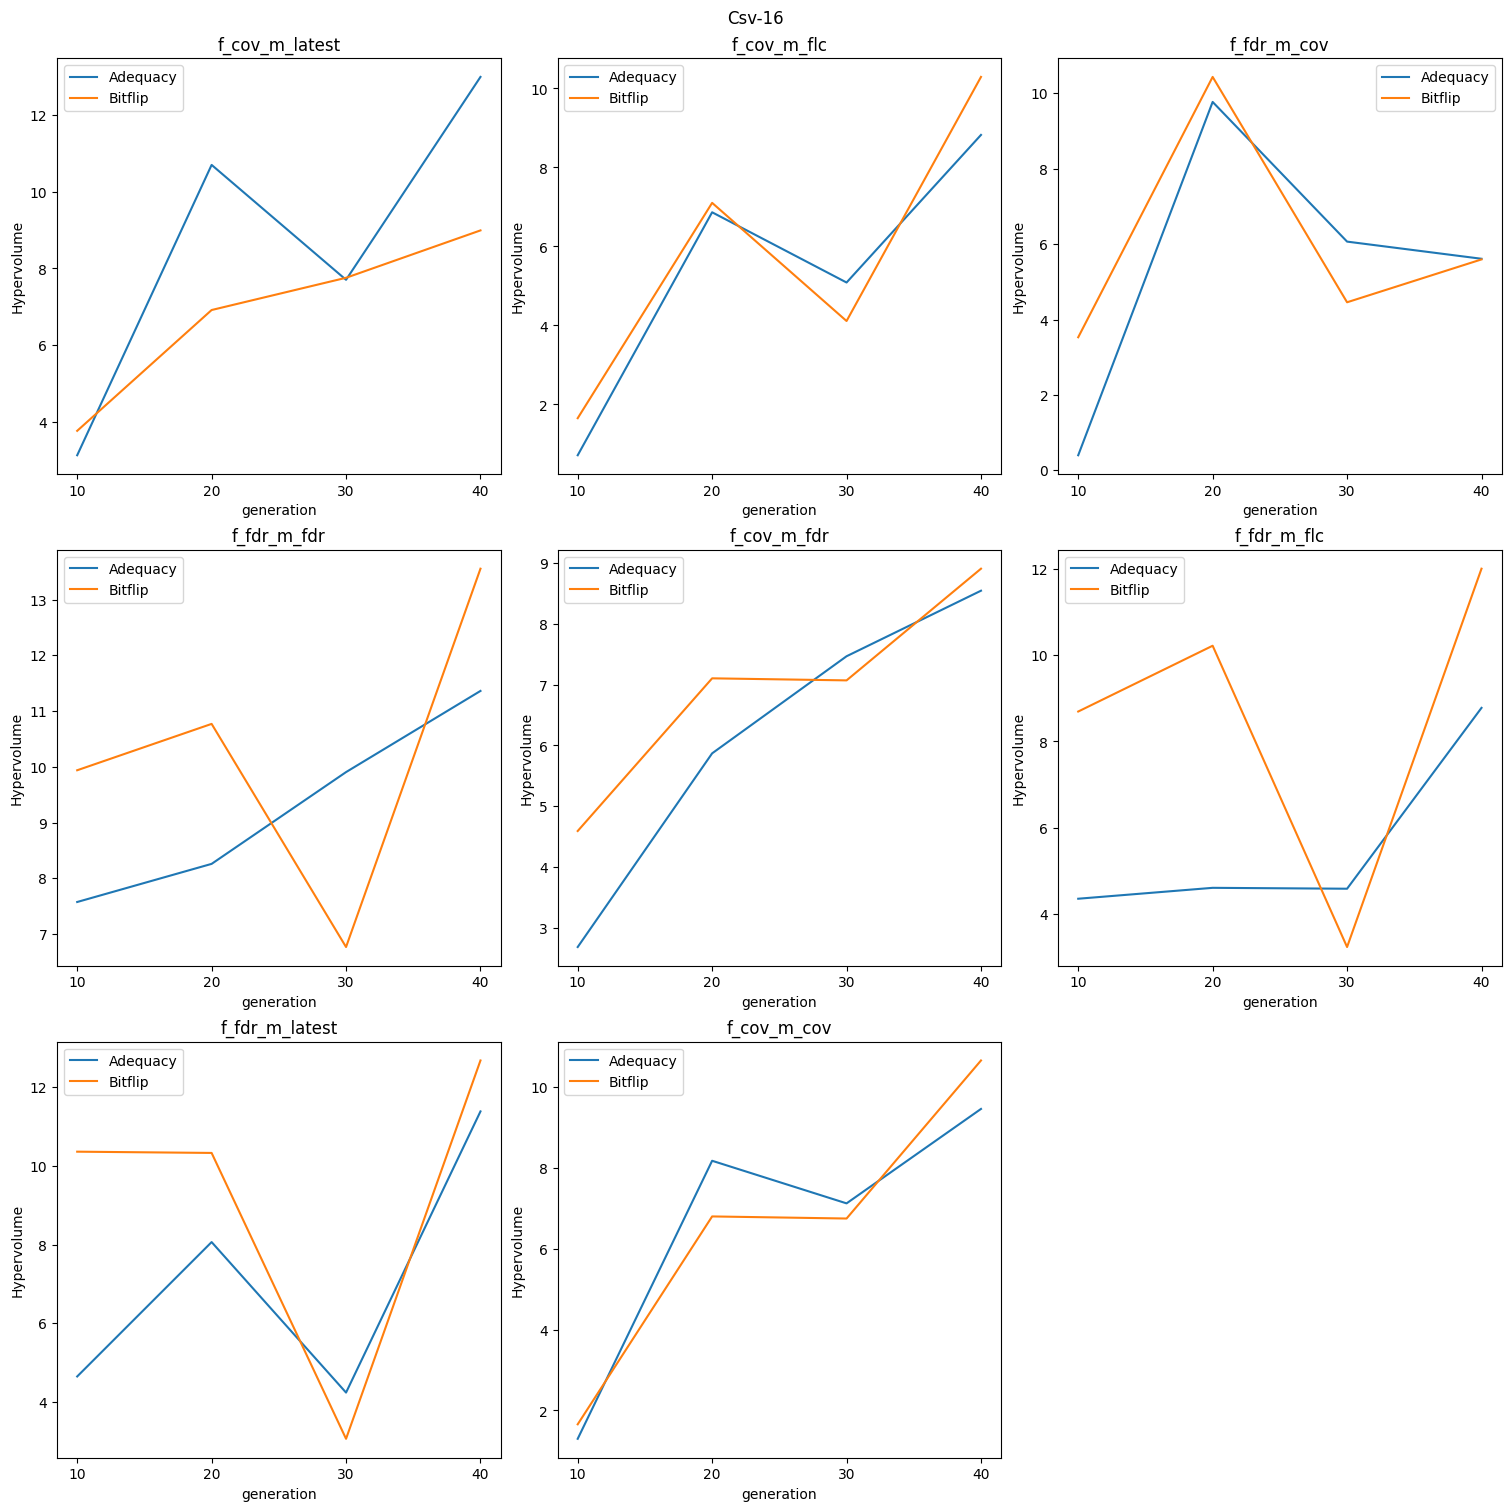

In [27]:
gx = ['10', '20', '30', '40']
for target in os.listdir('./data/merged_data/'):
    print(target)
    pid, vid = os.path.splitext(target)[0].split('_')
    # There is no data for Chart_1 ####
    if pid == "Chart":
        continue
    #####################
    plt.figure(figsize=(15, 15), constrained_layout=True)
    result_dir = f"./data/experiment_result/10_generation/"
    for j, type in enumerate(os.listdir(result_dir)):
        print(type)
        ax = plt.subplot(3, 3, j+1)
        hc_result_adeq = []
        hc_result_bitflip = []
        for generation in gx:
            with open(f'./data/experiment_result/{generation}_generation/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
                bitflip = pickle.load(f)
            with open(f'./data/experiment_result/{generation}_generation/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
                adeq = pickle.load(f)
            with open(f'./data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
                merged_data = pickle.load(f)
            with open(f"./data/killmap/{pid}-{vid}_fdr.json", "rb") as f:
                killmap = json.load(f)[f"{pid}_{vid}"]
            with open(f"./data/all_class_mutation/{pid}-{vid}_fdr.json", "rb") as f:
                fdr = json.load(f)[f"{pid}_{vid}"]

            
            total_mutant = fdr[list(fdr.keys())[0]]["mutants-generated"]
            bitflip_result = []
            adeq_result = []
            for i, sol in enumerate(bitflip.X):
                bitflip_kill = set()
                for test in merged_data.index[sol]:
                    if test in killmap:
                        bitflip_kill = bitflip_kill.union(set(killmap[test]))
                mut_score = len(bitflip_kill) / total_mutant
                bitflip_result.append([bitflip.F[i][0], mut_score])
            
            for i, sol in enumerate(adeq.X):
                adeq_kill = set()
                for test in merged_data.index[sol]:
                    if test in killmap:
                        adeq_kill = adeq_kill.union(set(killmap[test]))
                mut_score = len(adeq_kill) / total_mutant
                adeq_result.append([adeq.F[i][0], mut_score])
            
            max_tet = max(max(bitflip_result[:][0]), max(adeq_result[:][0]))
            min_fdr = min(min(bitflip_result[:][1]), min(adeq_result[:][1]))

            reference_point = [max_tet+0.001, max(min_fdr-0.001, 0)]

            bitflip_hypervolume = calculate_hypervolume(bitflip_result, reference_point)
            adeq_hypervolume = calculate_hypervolume(adeq_result, reference_point)

            hc_result_bitflip.append(bitflip_hypervolume)
            hc_result_adeq.append(adeq_hypervolume)
            
        plt.plot(gx, hc_result_adeq, label = "Adequacy")
        plt.plot(gx, hc_result_bitflip, label = "Bitflip")
        plt.xlabel("generation")
        plt.ylabel("Hypervolume")
        plt.title(type)
        plt.legend()
    

    
        print(hc_result_bitflip)
        print(hc_result_adeq)
    plt.suptitle(f"{pid}-{vid}")
    plt.show()